In [1]:
import sys
sys.path.append('../')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pyro
from pyro.distributions import Categorical, Normal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pandas as pd
import numpy as np
import utils.custom_dataset
import matplotlib.pyplot as plt
from matplotlib import colors
import os
from torch.utils.data.dataset import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import matplotlib as plt
from utils.Plot import plot_confusion_matrix
num_iterations = 30
num_features=1563
class NN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output


net = NN(num_features, 1024, 5)
log_softmax = nn.LogSoftmax(dim=1)


def model(x_data, y_data):
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    lhat = log_softmax(lifted_reg_model(x_data))
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)


num_samples = 10


def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1),mean


softplus = torch.nn.Softplus()


def guide(x_data, y_data):
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    lifted_module = pyro.random_module("module", net, priors)
    return lifted_module()


optim = Adam({"lr": 0.01})

'''
for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1, 28 * 28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train

    print("Epoch ", j, " Loss ", total_epoch_loss_train)

   '''
seed = 1200
annotation_path = "../Data/data/preprocessed_annotation_global.csv"
y = pd.read_csv(annotation_path)["label"]

y = y.astype('category').cat.codes

meth_path = "../Data/data/preprocessed_Matrix_meth.csv"
mRNA_path = "../Data/data/preprocessed_Matrix_miRNA_deseq_correct.csv"
mRNA_normalized_path = "../Data/data/preprocessed_Matrix_mRNA_deseq_normalized_prot_coding_correct.csv"
files = [mRNA_path]
filenames = [ "mrna"]

for file, filename in zip(files, filenames):
    with open('../Data/outputs/'+filename+'-bnn-output.txt', 'w') as f:
        X = pd.read_csv(file).drop(columns=["Composite Element REF", "Unnamed: 0"])
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
        dataset = utils.custom_dataset.CustomDataset(X_train.to_numpy(), y_train.to_numpy(),
                                                     transform=utils.custom_dataset.ToTensor())
        loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)
        svi = SVI(model, guide, optim, loss=Trace_ELBO())

        loss = 0
        for j in range(num_iterations):
            loss = 0
            for batch_id, data in enumerate(loader):
                # calculate the loss and take a gradient step
                loss += svi.step(data["X"].view(-1, data["X"].shape[1]), data["y"])
            normalizer_train = len(loader.dataset)
            total_epoch_loss_train = loss / normalizer_train

            print("Epoch ", j, " Loss ", total_epoch_loss_train)
            print("Epoch ", j, " Loss ", total_epoch_loss_train,file=f)
        print(filename)

       

Epoch  0  Loss  84198.00430613048
Epoch  1  Loss  63412.4861906156
Epoch  2  Loss  48938.37043017403
Epoch  3  Loss  40133.55478757909
Epoch  4  Loss  32984.743889691024
Epoch  5  Loss  28639.80993861634
Epoch  6  Loss  24814.853980786298
Epoch  7  Loss  22231.16894328822
Epoch  8  Loss  20144.11523117648
Epoch  9  Loss  18397.51295515444
Epoch  10  Loss  17800.681007098872
Epoch  11  Loss  16103.355050502894
Epoch  12  Loss  14907.144842393598
Epoch  13  Loss  13971.746803584778
Epoch  14  Loss  13169.336015318284
Epoch  15  Loss  12546.998538868718
Epoch  16  Loss  12069.195438720406
Epoch  17  Loss  11573.035929101505
Epoch  18  Loss  10908.089241152467
Epoch  19  Loss  10494.45176257261
Epoch  20  Loss  10363.123986557892
Epoch  21  Loss  9658.755596740655
Epoch  22  Loss  9090.1771603933
Epoch  23  Loss  8834.89123506378
Epoch  24  Loss  8293.627997482401
Epoch  25  Loss  8120.0003564221215
Epoch  26  Loss  7858.0394159196585
Epoch  27  Loss  7327.291246349066
Epoch  28  Loss  751

In [22]:
 num_samples = 100


def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1),mean


print('Prediction when network is forced to predict')
correct = 0
total = 0
dataset = utils.custom_dataset.CustomDataset(X_test.to_numpy(), y_test.to_numpy(),
                                             transform=utils.custom_dataset.ToTensor())
loader = torch.utils.data.DataLoader(dataset, batch_size=32)
probabilities = np.ndarray(shape=(0,5))
true_labels= np.ndarray([])
for j, data in enumerate(loader):
    images = data["X"]
    labels = data["y"]
    predicted,mean = predict(images.view(-1, num_features))
    probabilities=np.append(probabilities,mean,axis=0)
    true_labels = np.append(true_labels, labels)
    total += labels.size(0)
    correct += (torch.from_numpy(predicted) == labels).sum().item()
print("accuracy: %d %%" % (100 * correct / total))
#print("accuracy: %d %%" % (100 * correct / total),file=f)
import pandas as pd

#pd.DataFrame(probabilities).to_csv("../Data/outputs/pred-bnn-"+filename+".csv")
        #pd.DataFrame(true_labels).to_csv("../Data/outputs/true-labels.csv")






Prediction when network is forced to predict
accuracy: 94 %


In [23]:


def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,num_features)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)
    #mean = torch.mean(torch.stack(yhats), 0)
    #return np.argmax(mean, axis=1)

In [25]:
y10 = give_uncertainities(images)
sampled_models

NameError: name 'sampled_models' is not defined

In [16]:
classes=y.astype('category').cat.categories

In [17]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.imshow(npimg,  cmap='gray')
    #fig.show(figsize=(1,1))
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [63]:
def test_batch(images, labels, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions=0

    for i in range(len(labels)):
    
        if(plot):
            print("Real: ",labels[i].item())
            fig, axs = plt.subplots(1, 5, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
            print(prob)
            if(prob>0.7): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)           
            if(plot):
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(classes[j])+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

    
        if(plot):
            plt.show()
    
        predicted = np.argmax(all_digits_prob)
        print(i)
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        
    return len(labels), correct_predictions, predicted_for_images

Real:  0
1.0
0.0
0.0
0.0
0.0


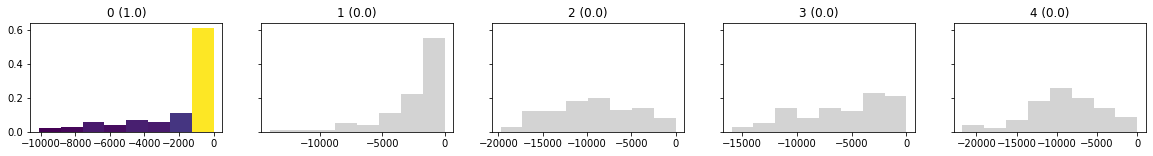

0
Correct
Summary
Total images:  1
Predicted for:  1
Accuracy when predicted:  1.0


(1, 1.0, 1)

In [60]:
import matplotlib.pyplot as plt
test_batch(torch.from_numpy(X_test.to_numpy()[5]).float(),np.array([y_test.to_numpy()[5]]))

Real:  2
0.0
0.0
1.0
0.0
0.0


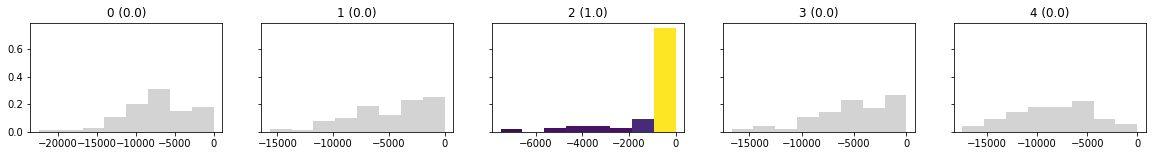

0
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


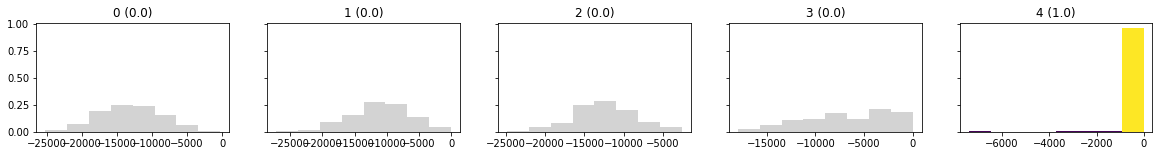

1
Correct
Real:  2
0.0
0.0
1.0
0.0
0.0


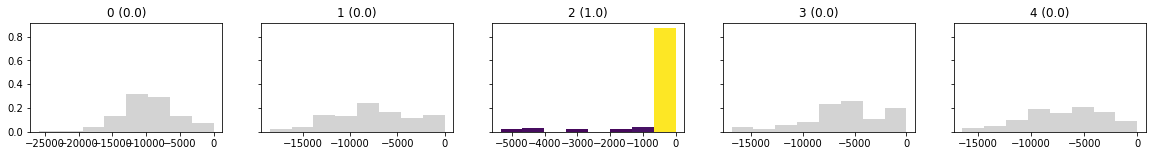

2
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


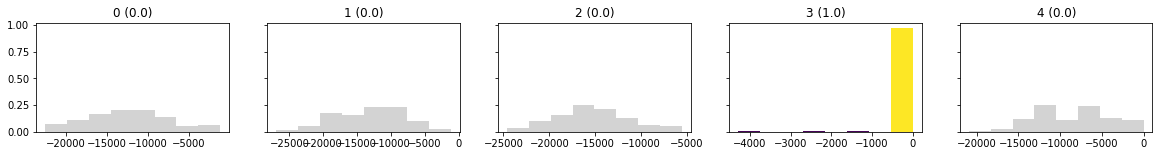

3
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


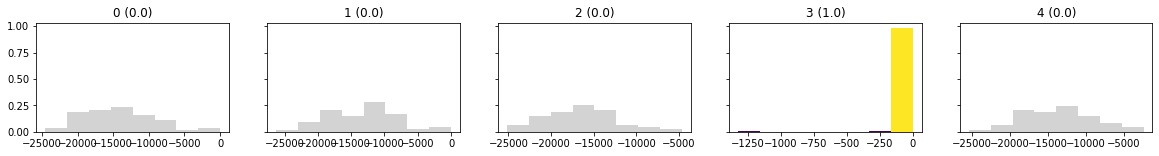

4
Correct
Real:  0
0.5
0.0
0.0
0.0
0.0


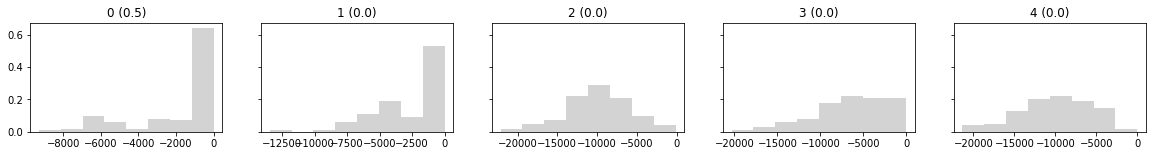

5
Undecided.
Real:  3
0.0
0.0
0.0
1.0
0.0


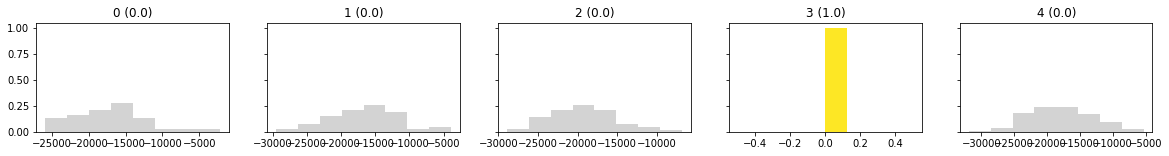

6
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


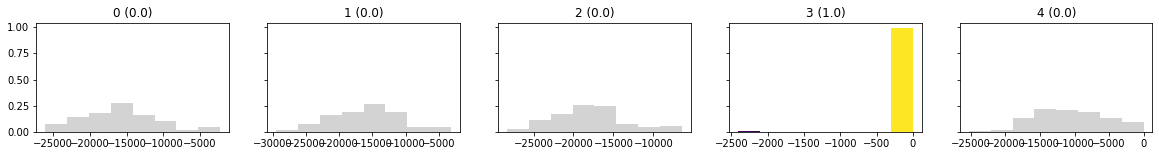

7
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


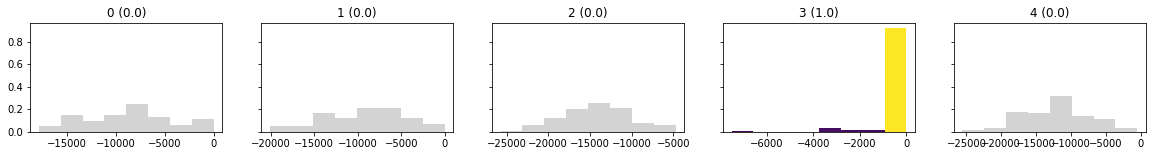

8
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


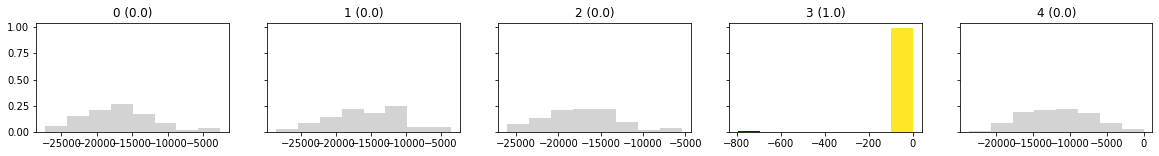

9
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


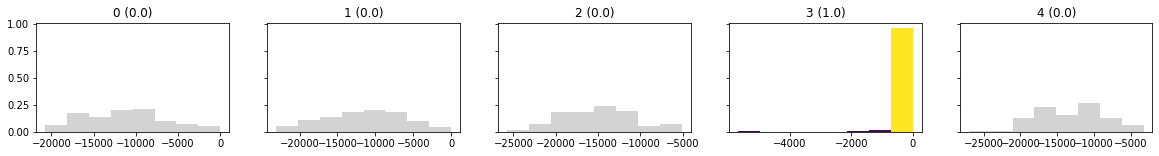

10
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


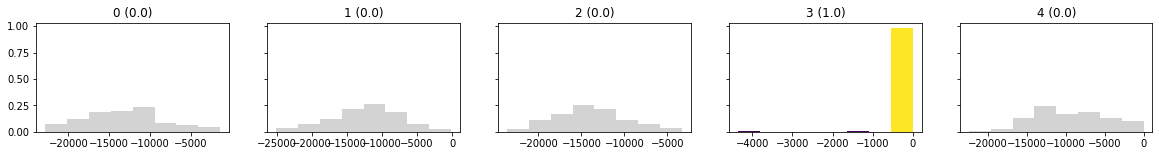

11
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


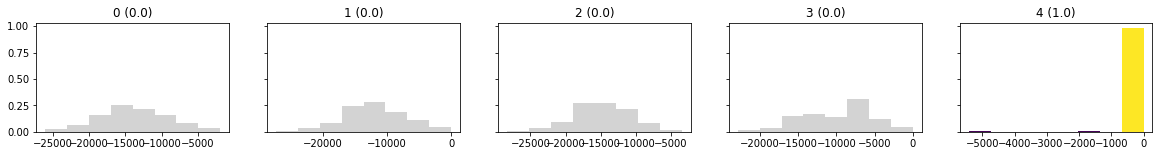

12
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


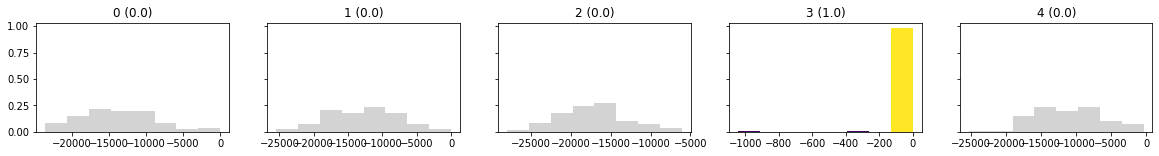

13
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


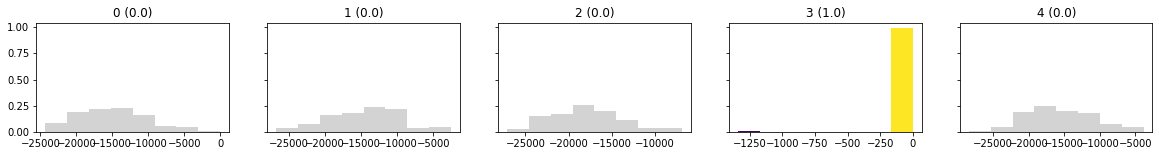

14
Correct
Real:  2
0.0
0.0
1.0
0.0
0.0


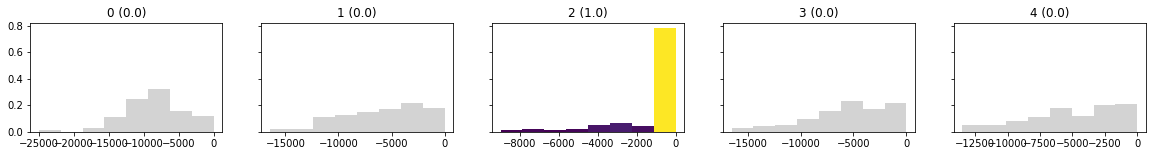

15
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


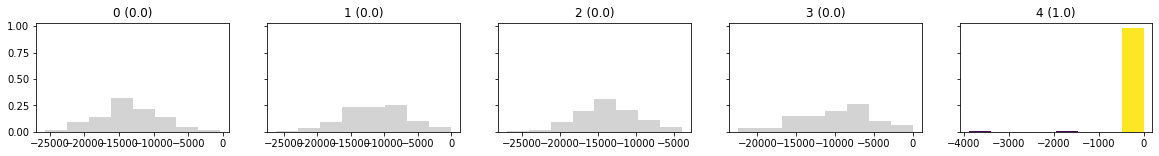

16
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


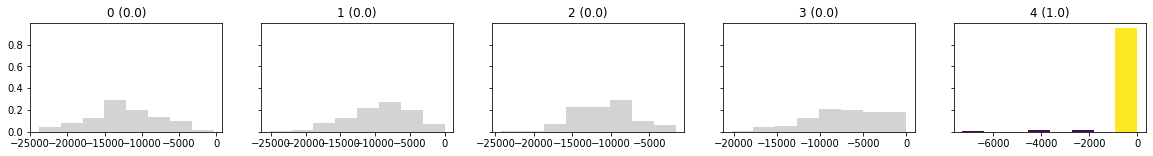

17
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


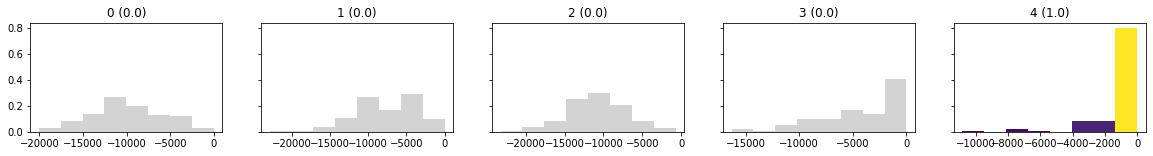

18
Correct
Real:  2
0.0
0.0
1.0
0.0
0.0


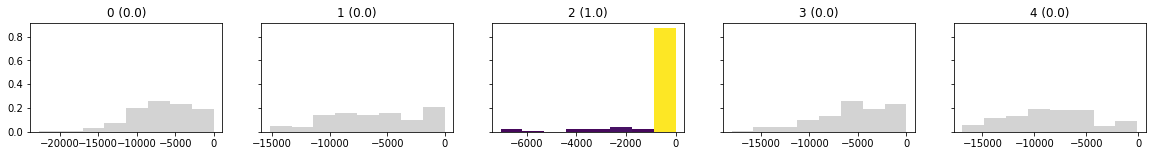

19
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


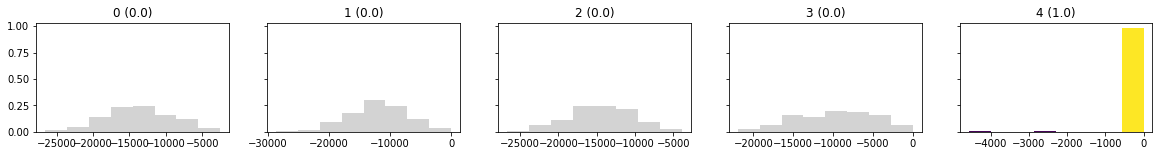

20
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


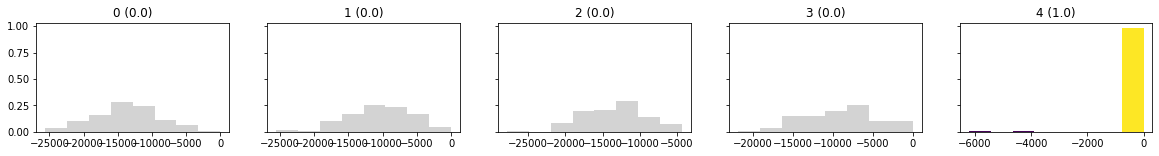

21
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


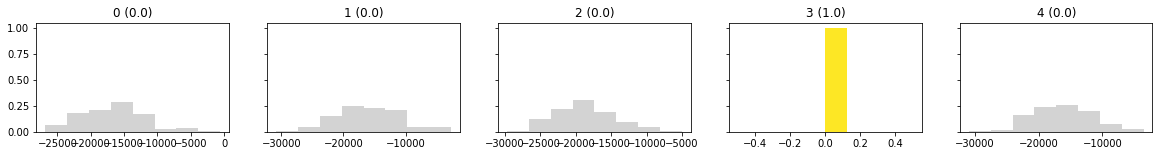

22
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


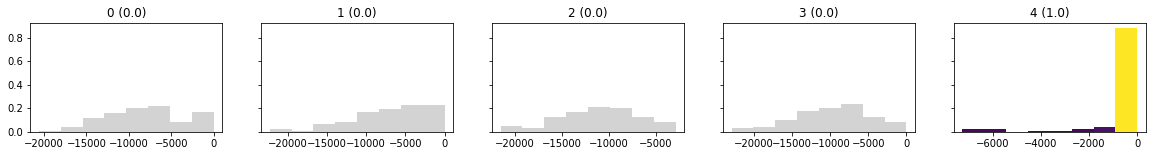

23
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


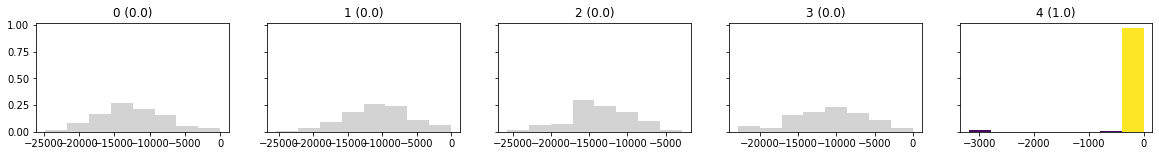

24
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


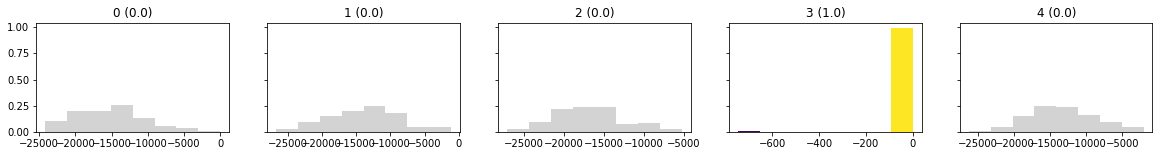

25
Correct
Real:  0
1.0
0.0
0.0
0.0
0.0


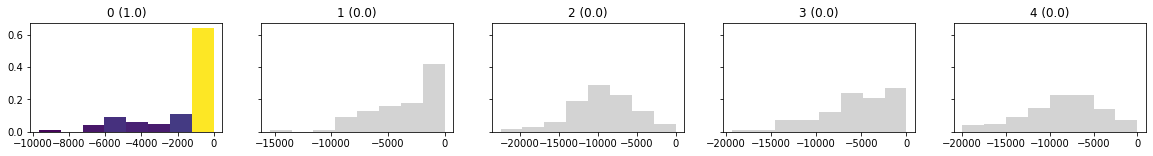

26
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


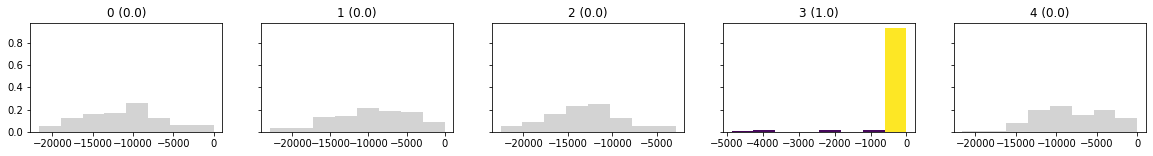

27
Correct
Real:  4
0.0
0.0
0.0
0.0
0.0


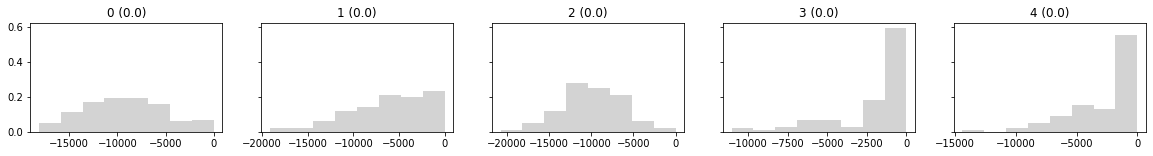

28
Undecided.
Real:  4
0.0
0.0
0.0
0.0
1.0


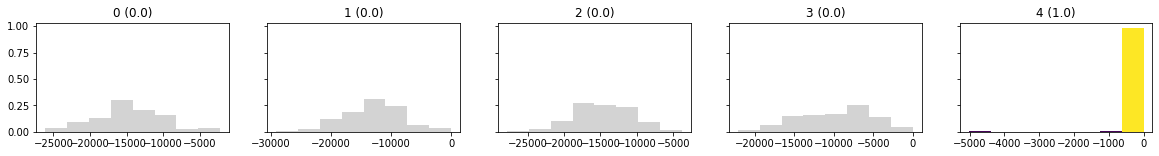

29
Correct
Real:  0
0.0
0.0
0.0
0.0
0.0


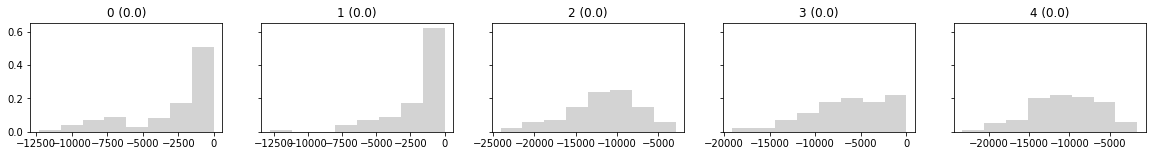

30
Undecided.
Real:  3
0.0
0.0
0.0
1.0
0.0


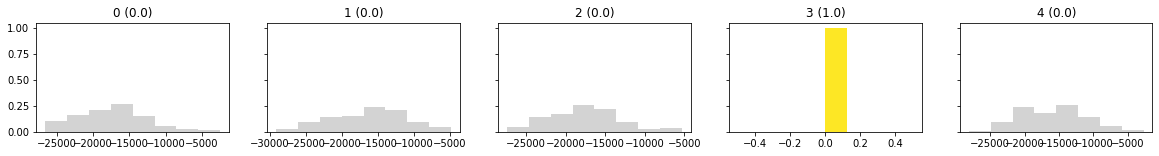

31
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


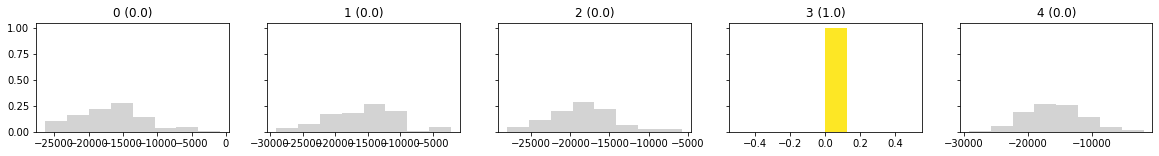

32
Correct
Real:  1
0.0
1.0
0.0
0.0
0.0


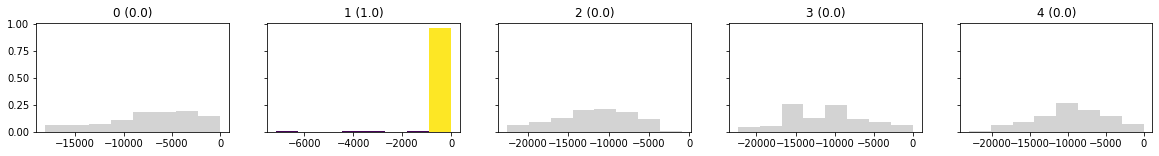

33
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


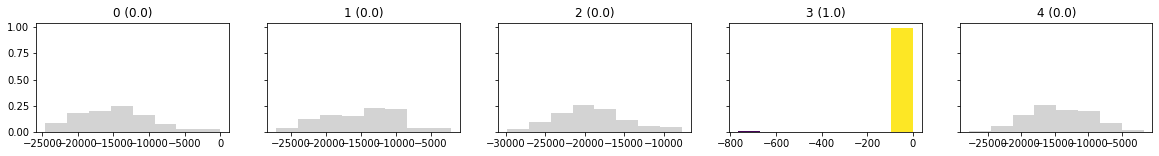

34
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


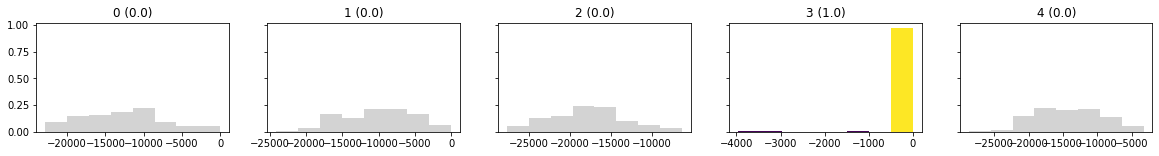

35
Correct
Real:  2
0.0
0.0
1.0
0.0
0.0


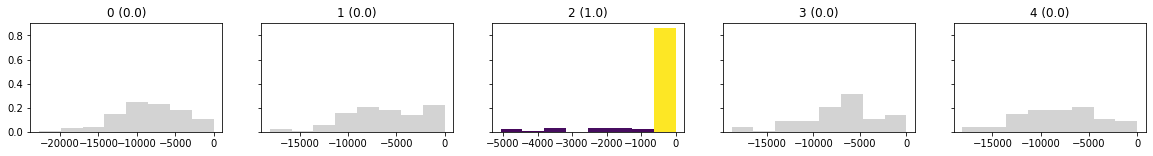

36
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


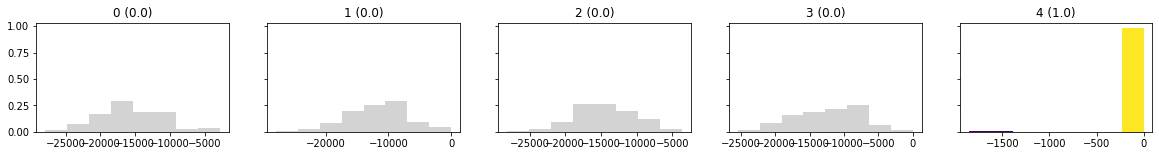

37
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


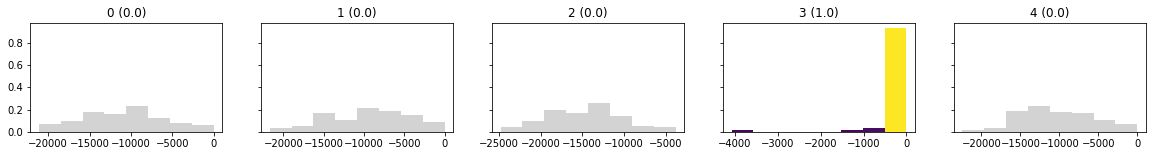

38
Correct
Real:  0
0.0
0.0
0.0
0.0
0.0


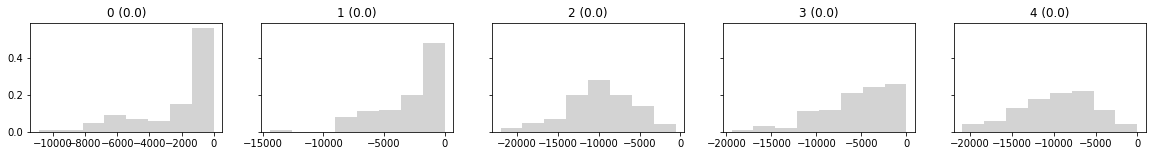

39
Undecided.
Real:  3
0.0
0.0
0.0
1.0
0.0


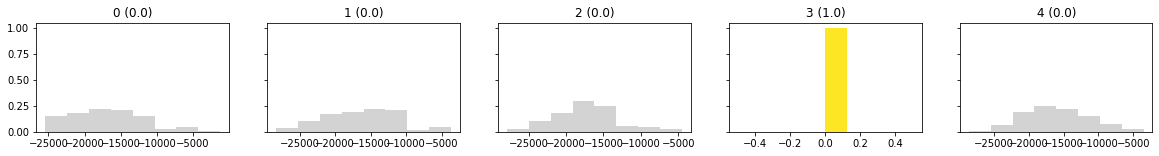

40
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


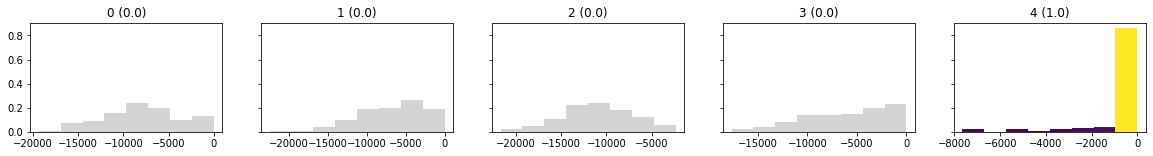

41
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


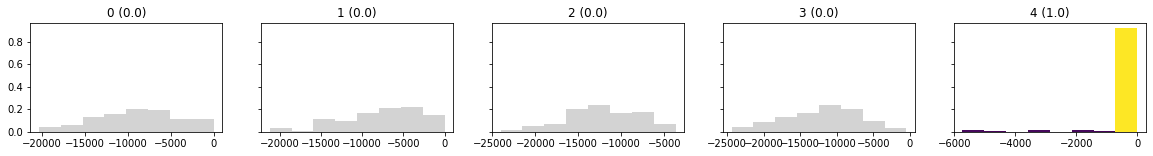

42
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


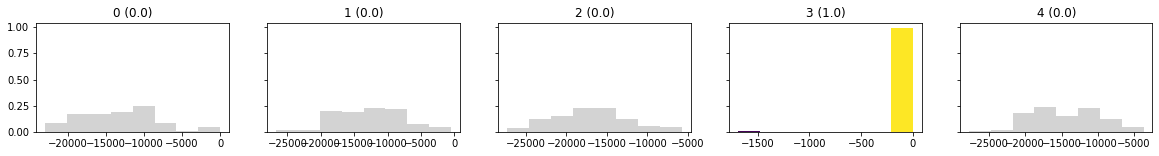

43
Correct
Real:  2
0.0
0.0
1.0
0.0
0.0


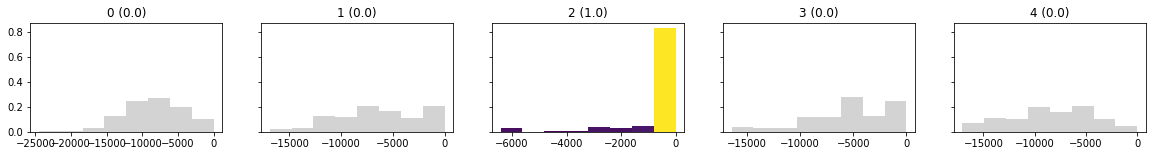

44
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


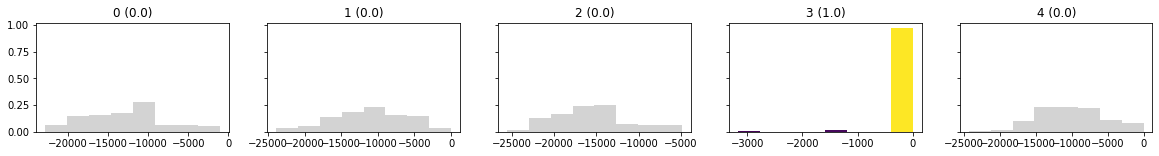

45
Correct
Real:  2
0.0
0.0
1.0
0.0
0.0


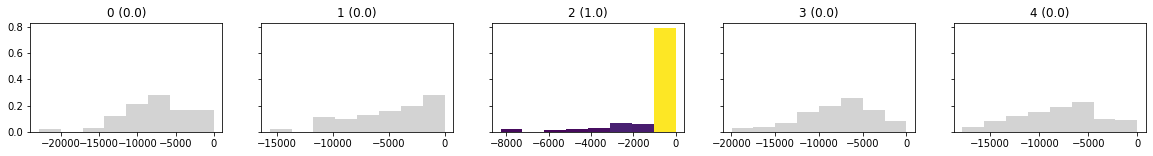

46
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


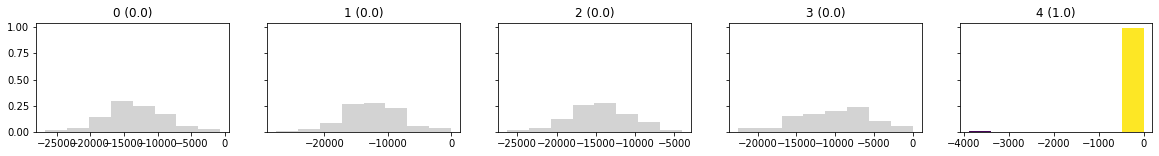

47
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


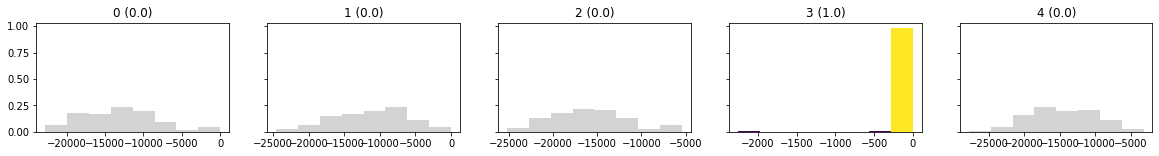

48
Correct
Real:  2
0.0
0.0
1.0
0.0
0.0


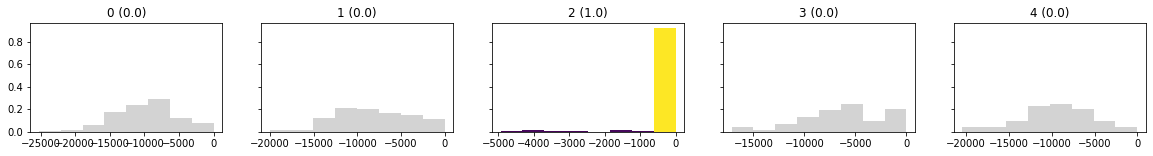

49
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


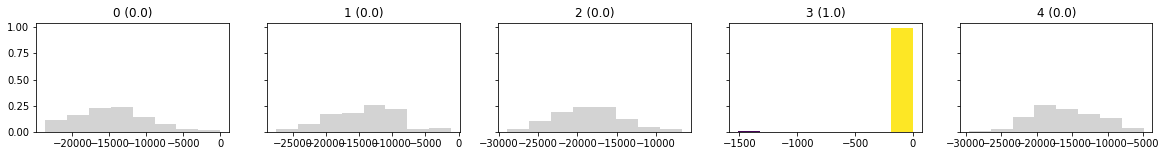

50
Correct
Real:  2
0.0
0.0
1.0
0.0
0.0


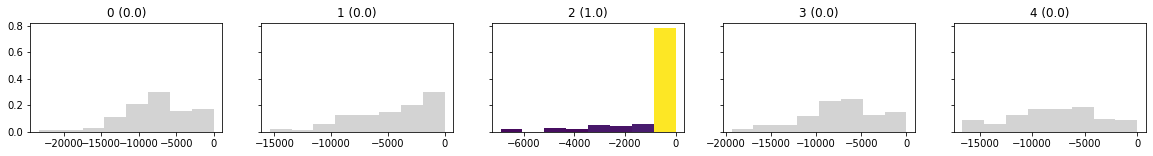

51
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


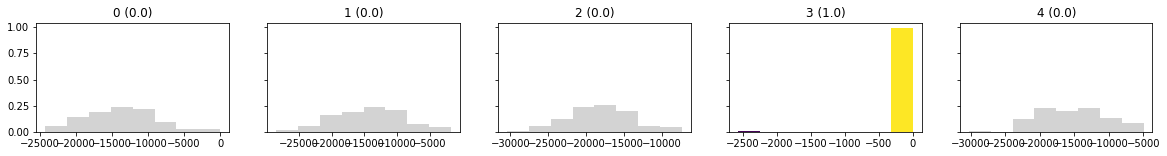

52
Correct
Real:  2
0.0
0.0
1.0
0.0
0.0


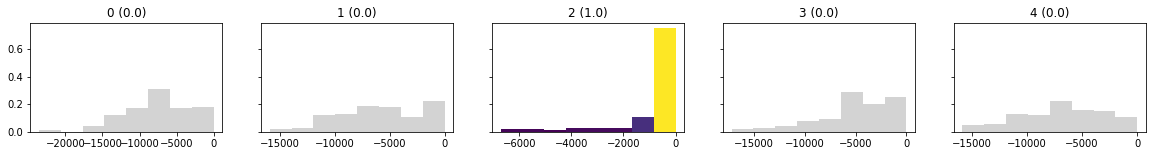

53
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


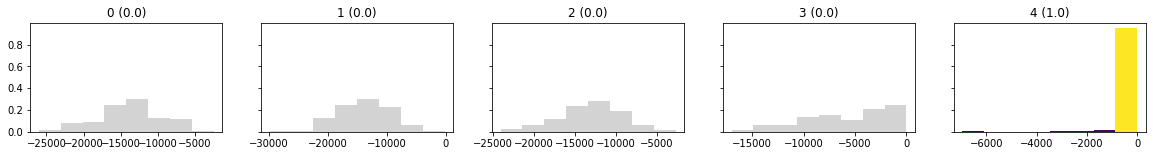

54
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


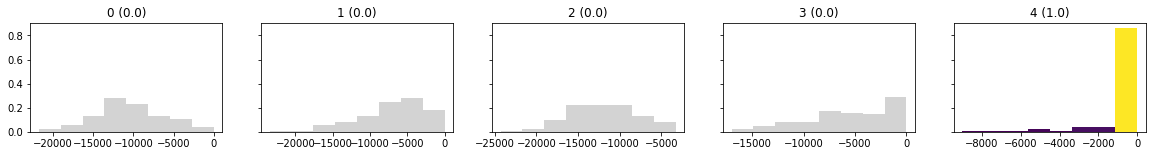

55
Correct
Real:  4
0.0
0.0
0.0
1.0
0.0


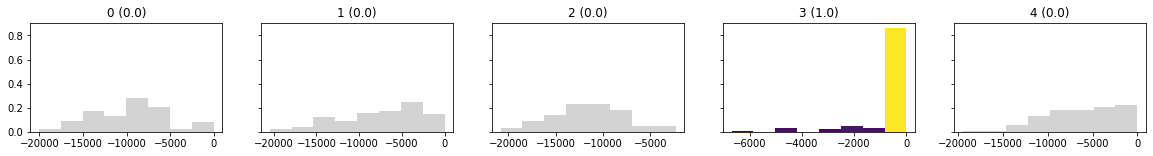

56
Incorrect :()
Real:  3
0.0
0.0
0.0
1.0
0.0


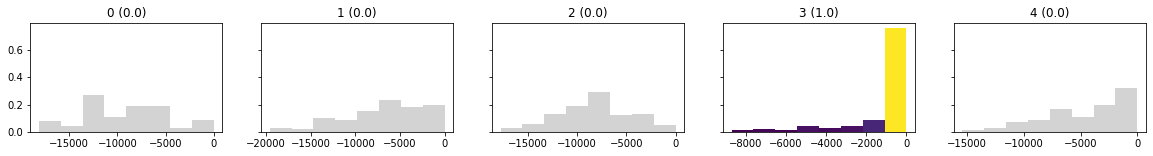

57
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


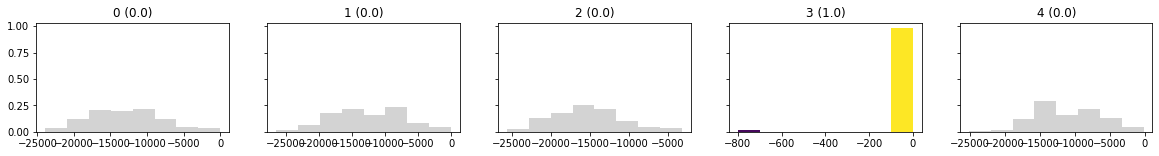

58
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


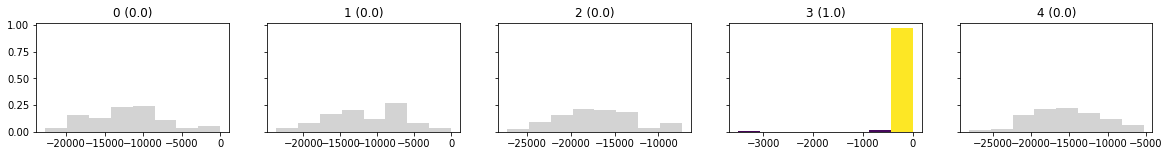

59
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


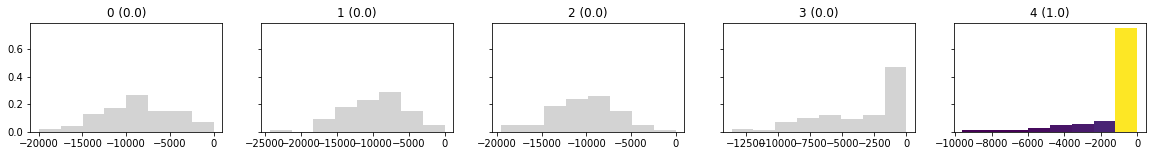

60
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


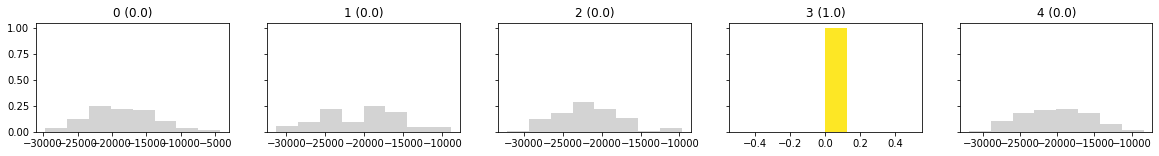

61
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


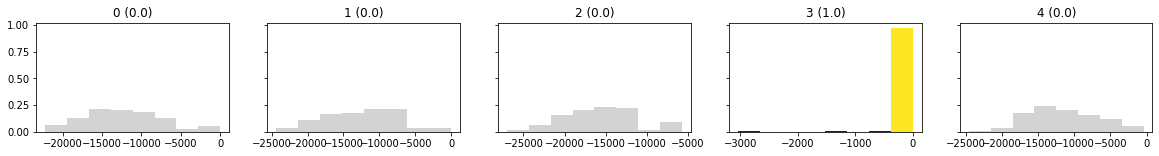

62
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


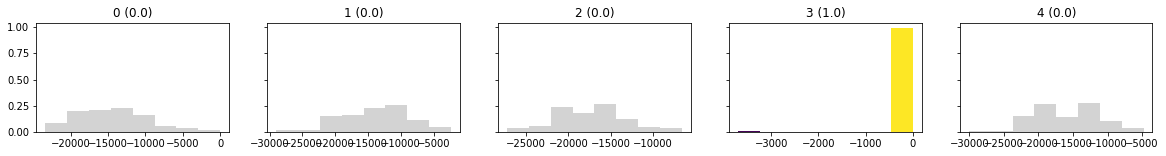

63
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


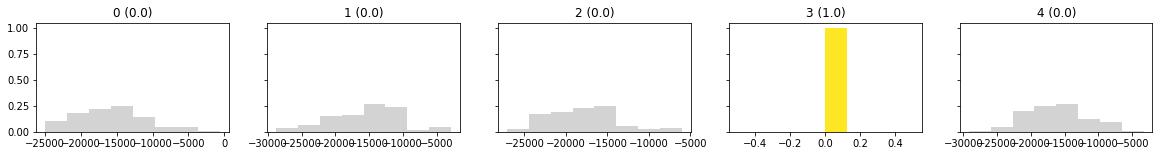

64
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


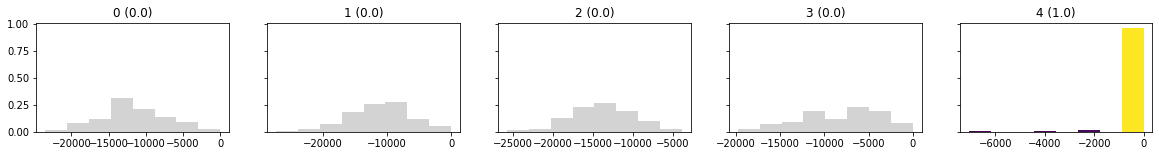

65
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


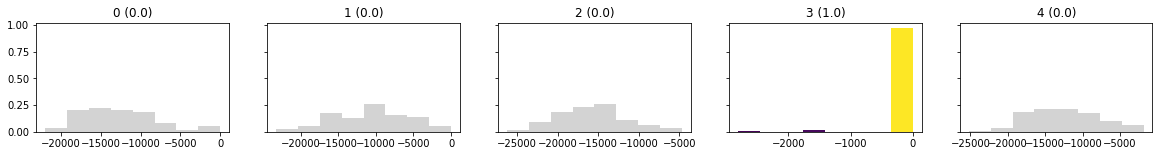

66
Correct
Real:  4
0.0
0.0
0.0
0.0
0.0


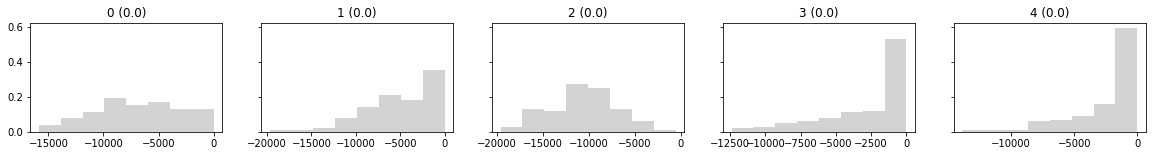

67
Undecided.
Real:  4
0.0
0.0
0.0
0.0
1.0


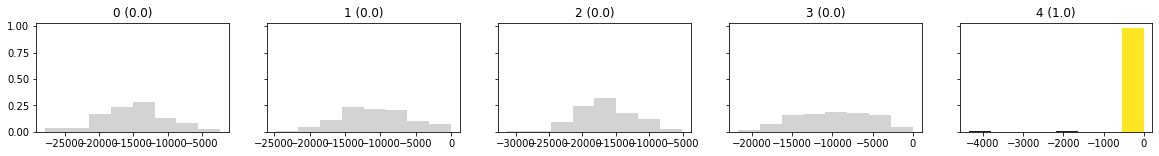

68
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


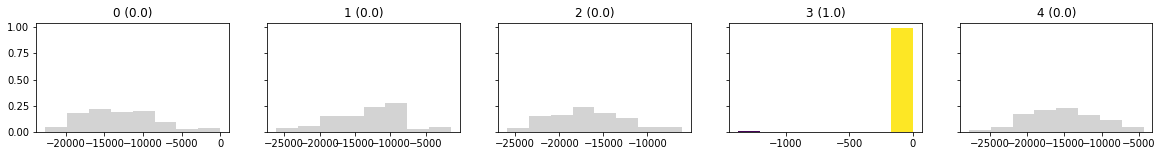

69
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


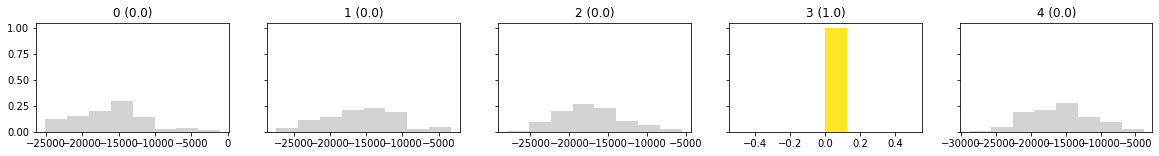

70
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


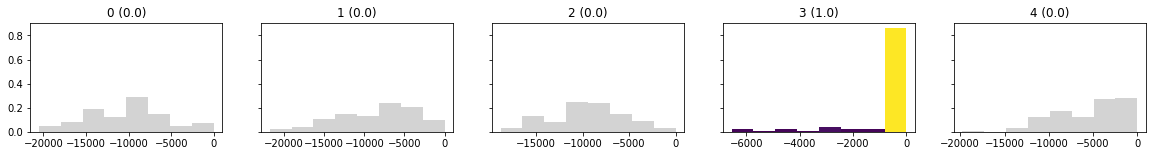

71
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


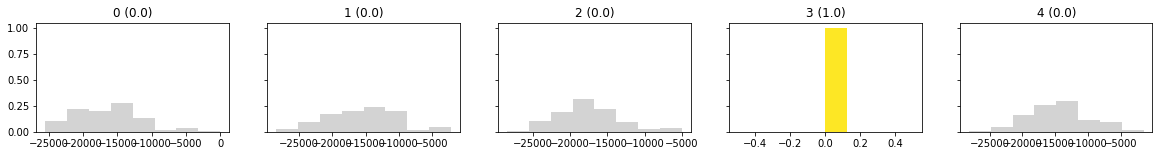

72
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


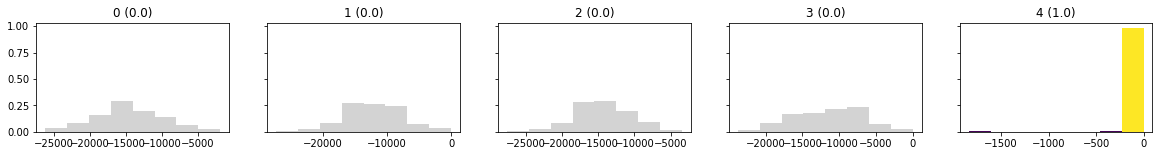

73
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


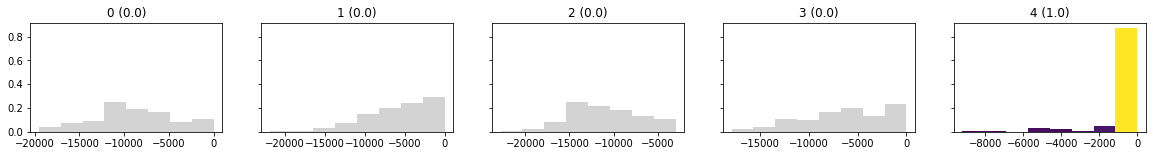

74
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


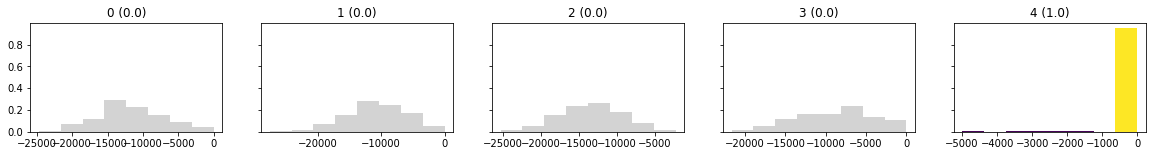

75
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


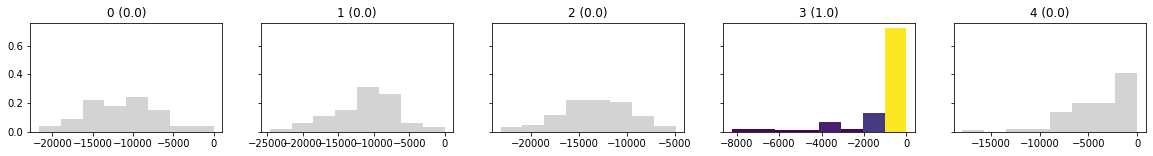

76
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


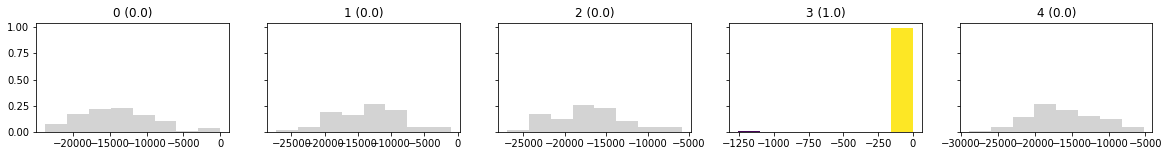

77
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


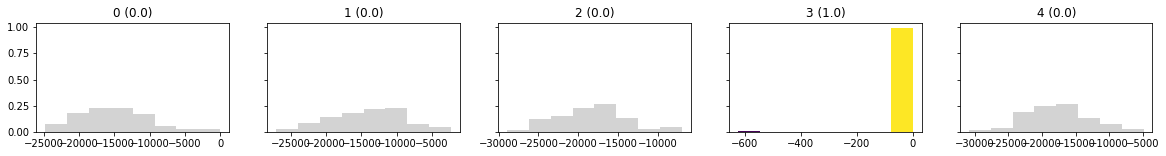

78
Correct
Real:  0
0.0
1.0
0.0
0.0
0.0


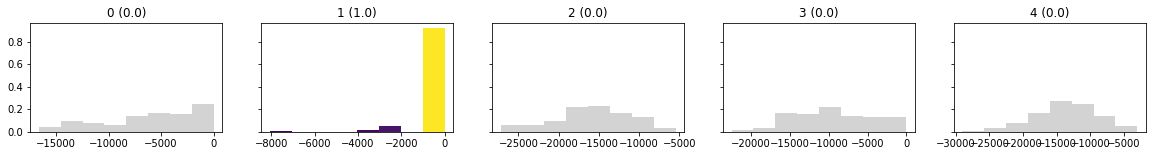

79
Incorrect :()
Real:  4
0.0
0.0
0.0
0.0
1.0


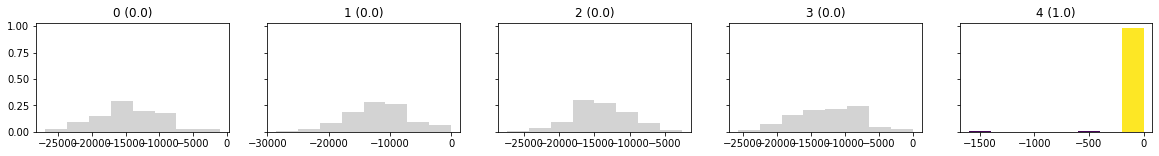

80
Correct
Real:  0
0.0
0.0
0.0
0.0
0.0


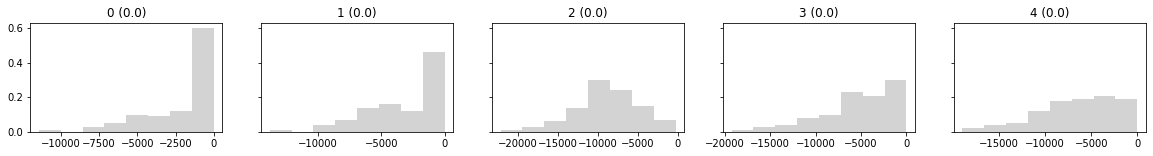

81
Undecided.
Real:  3
0.0
0.0
0.0
1.0
0.0


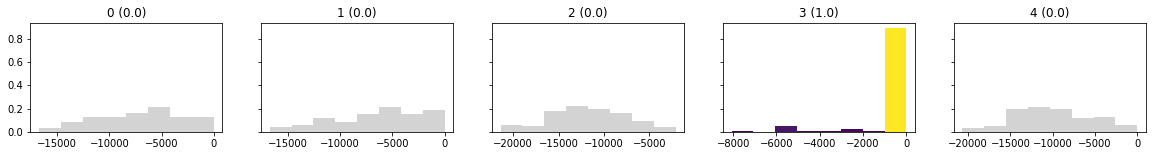

82
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


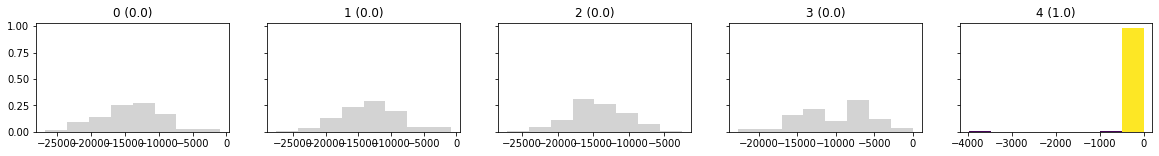

83
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


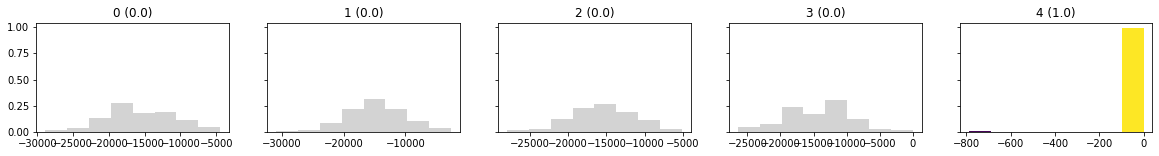

84
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


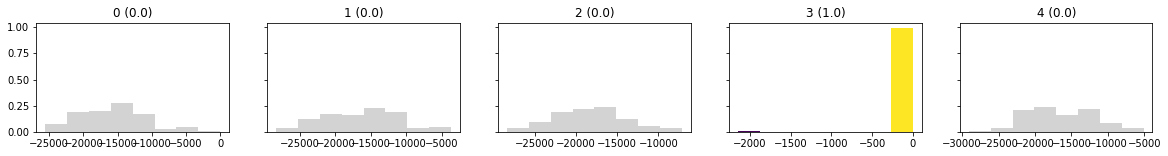

85
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


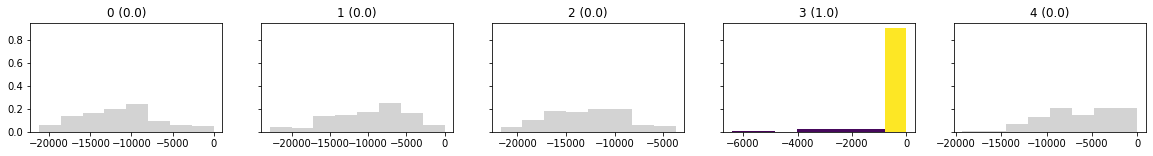

86
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


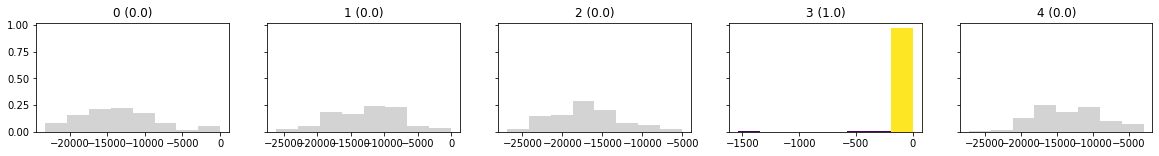

87
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


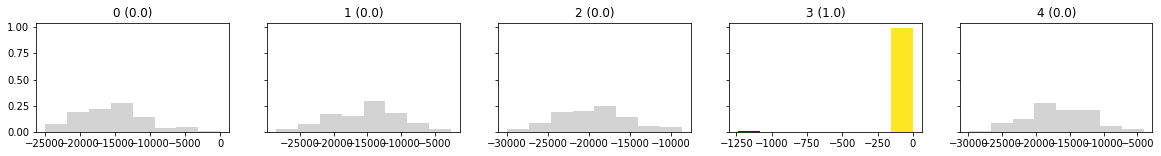

88
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


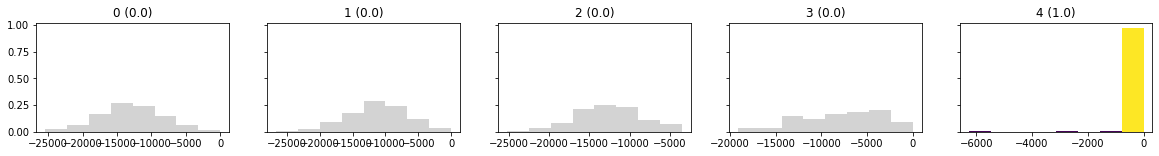

89
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


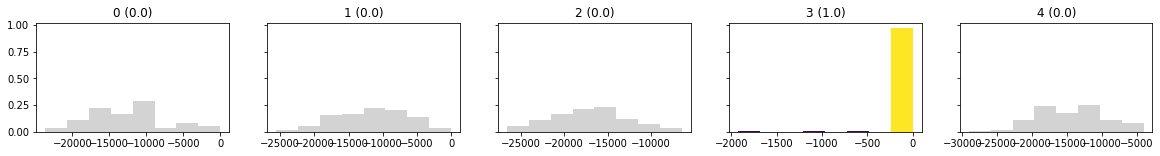

90
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


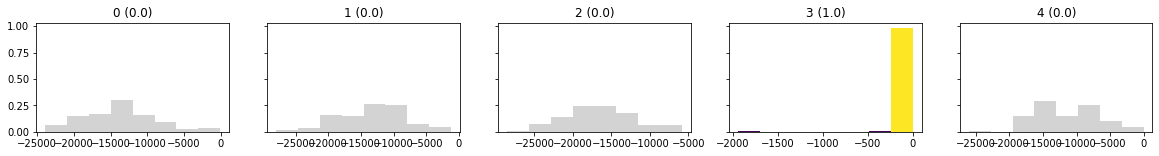

91
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


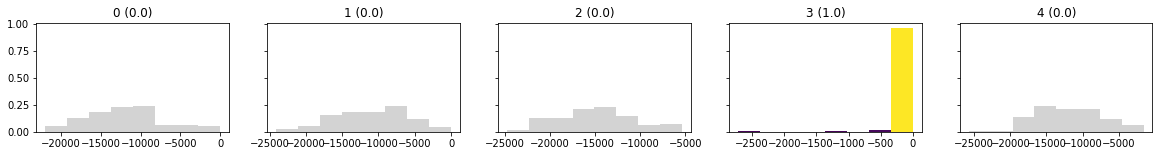

92
Correct
Real:  2
0.0
0.0
1.0
0.0
0.0


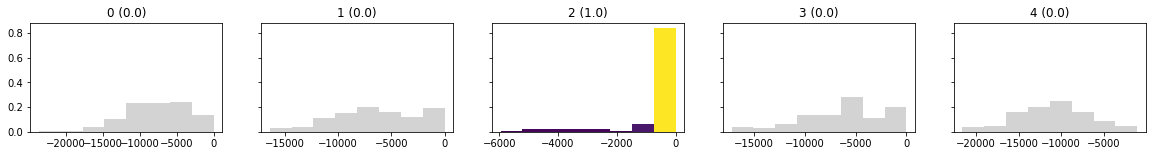

93
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


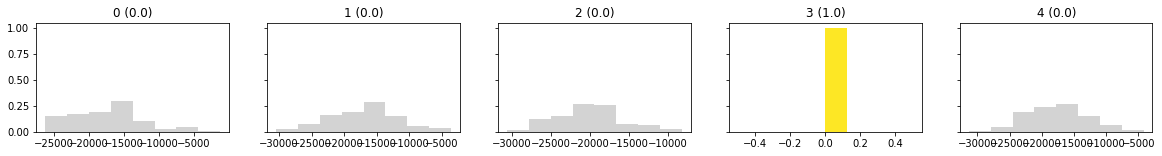

94
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


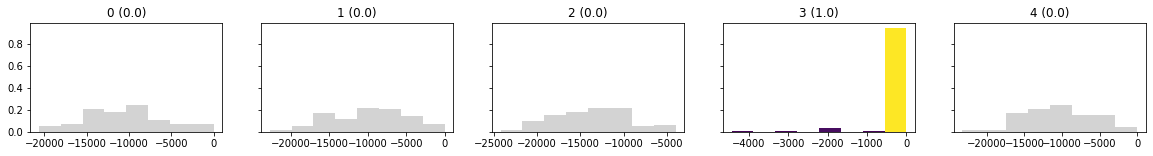

95
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


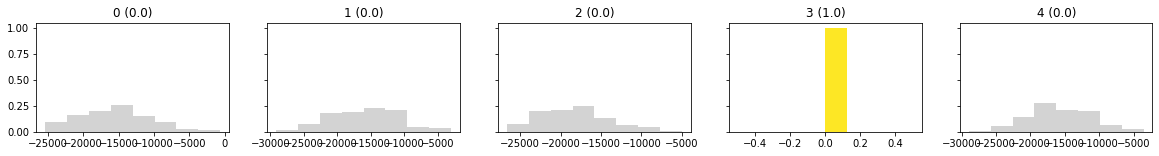

96
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


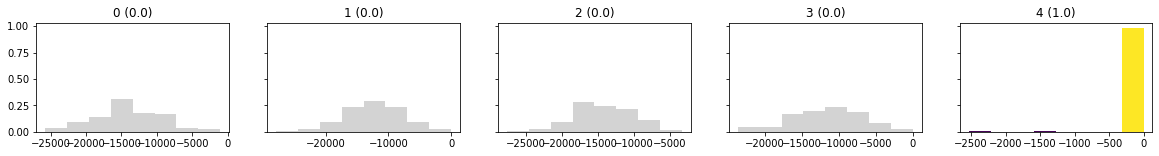

97
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


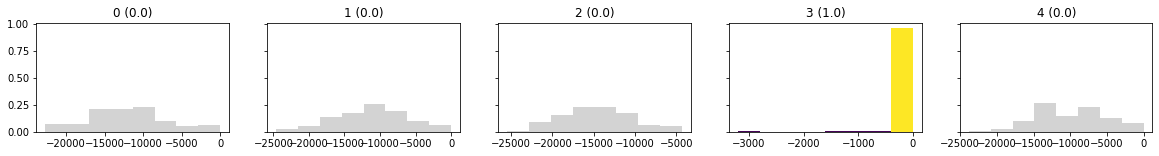

98
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


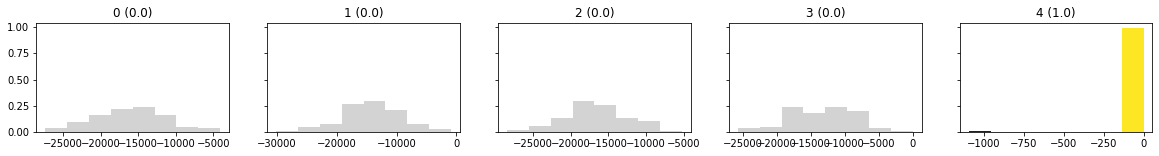

99
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


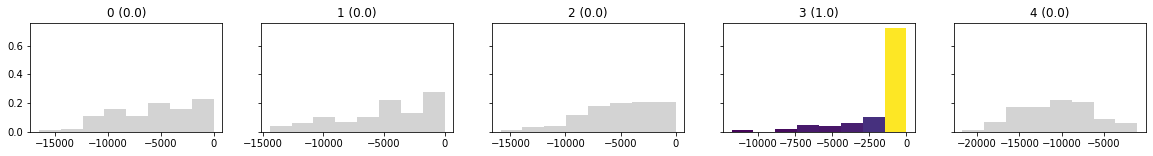

100
Correct
Real:  2
0.0
0.0
1.0
0.0
0.0


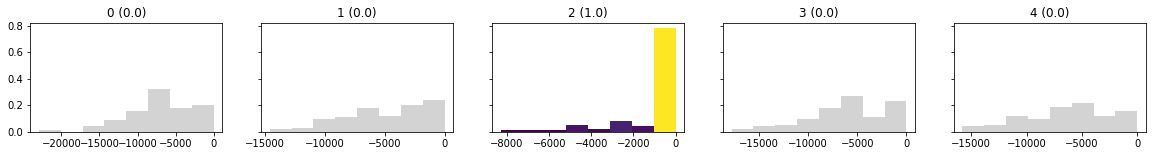

101
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


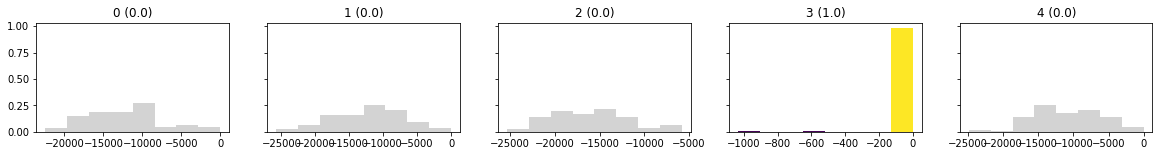

102
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


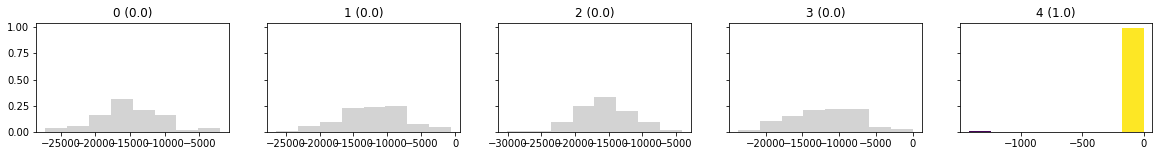

103
Correct
Real:  2
0.0
0.0
1.0
0.0
0.0


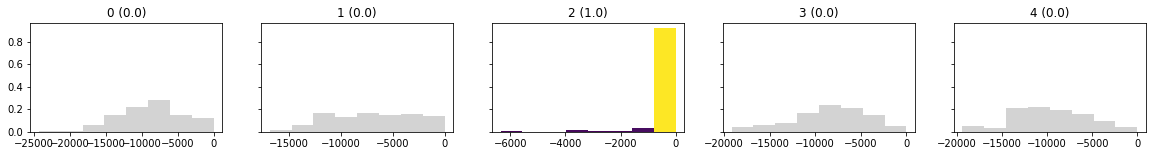

104
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


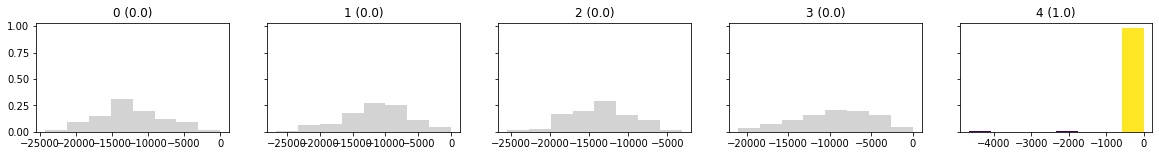

105
Correct
Real:  2
0.0
0.0
1.0
0.0
0.0


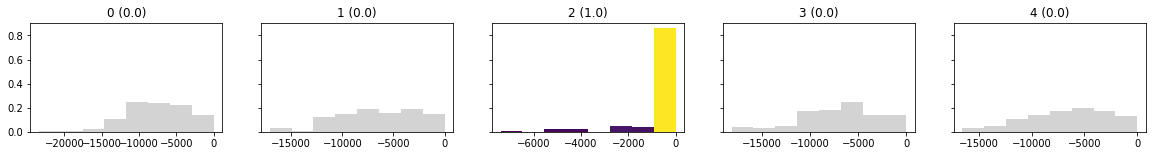

106
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


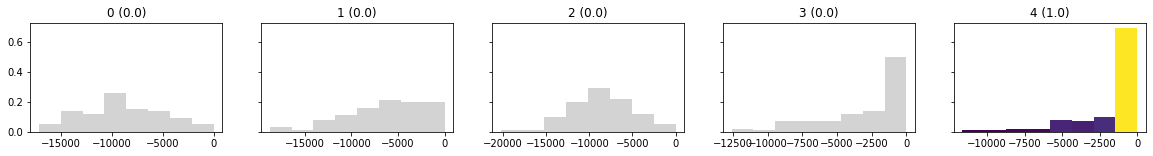

107
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


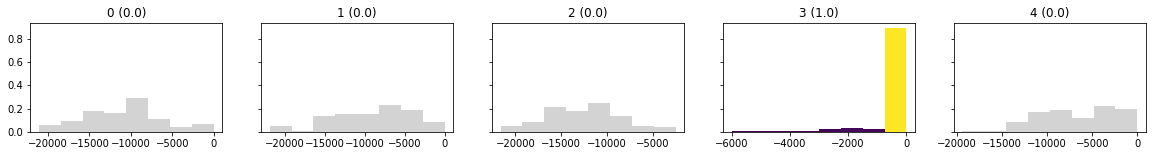

108
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


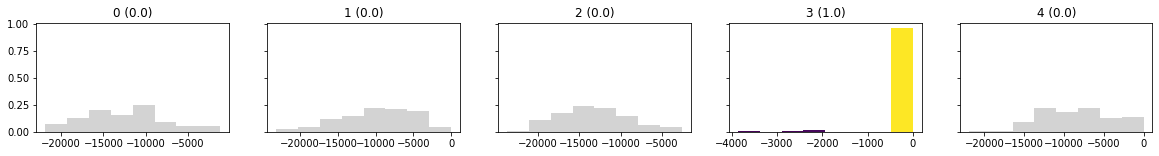

109
Correct
Real:  0
1.0
0.0
0.0
0.0
0.0


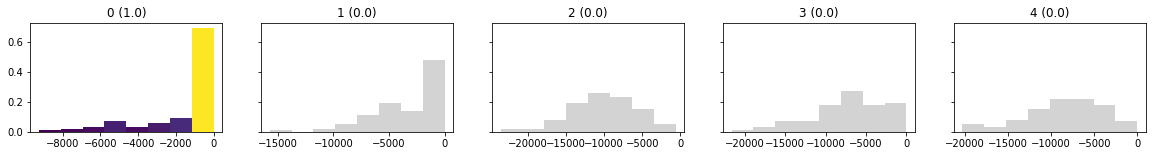

110
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


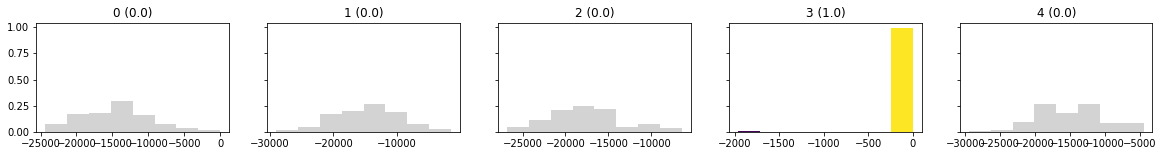

111
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


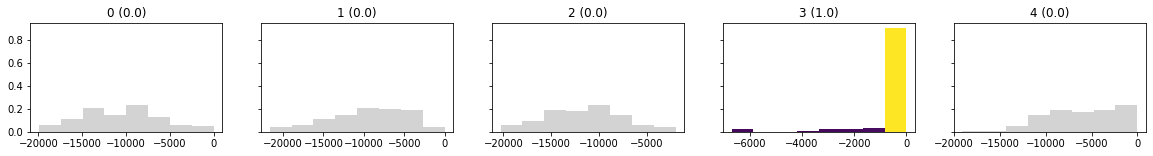

112
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


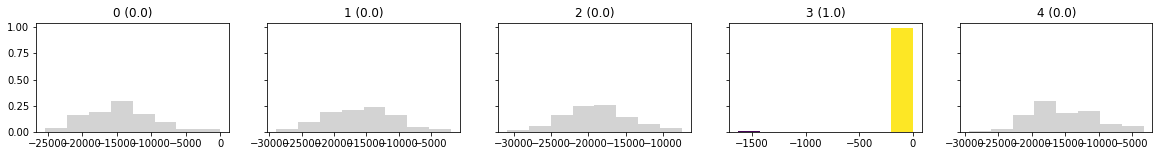

113
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


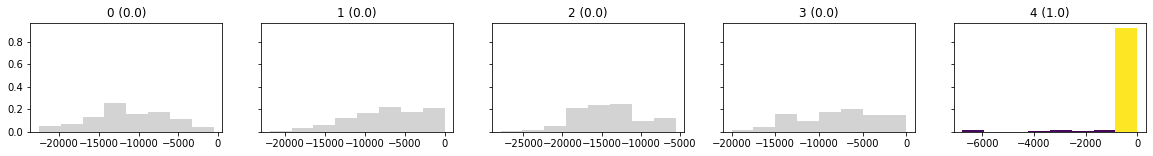

114
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


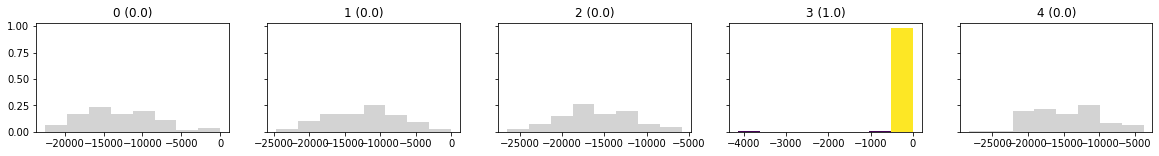

115
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


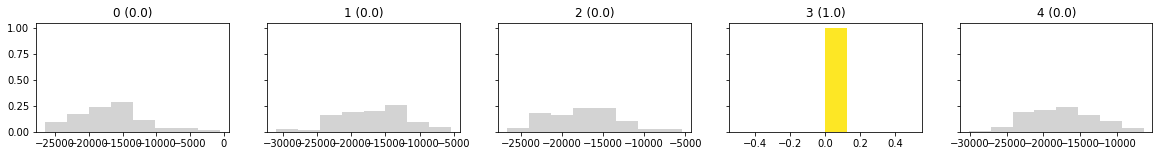

116
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


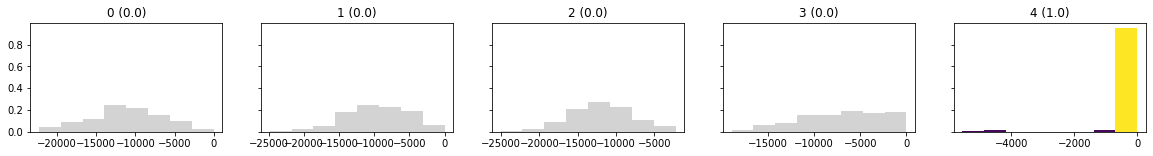

117
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


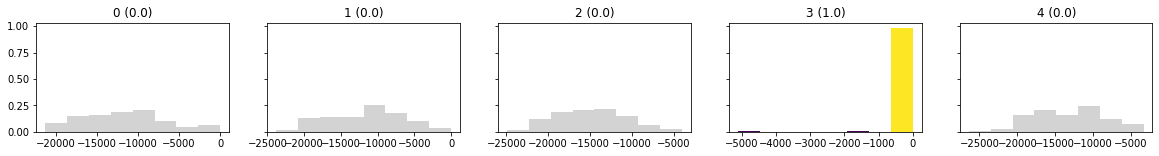

118
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


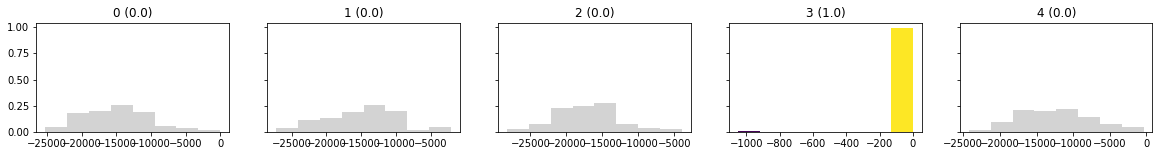

119
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


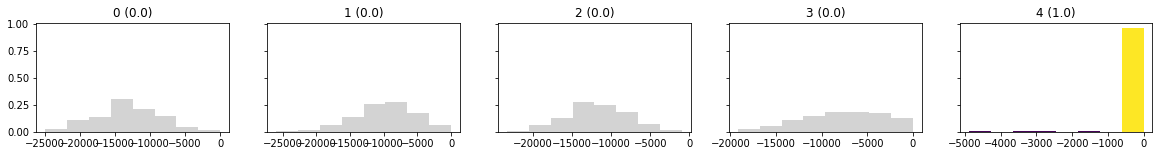

120
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


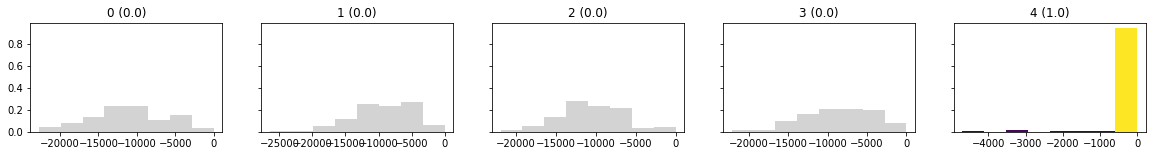

121
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


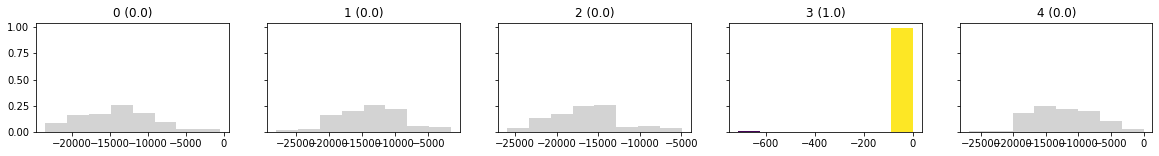

122
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


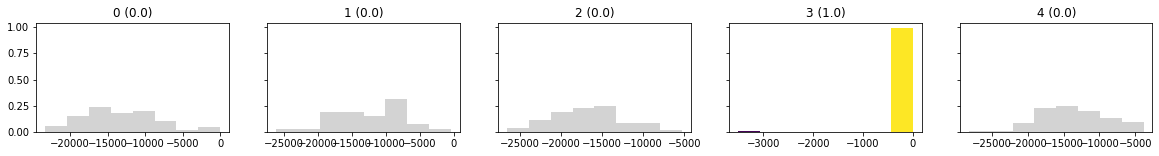

123
Correct
Real:  4
0.0
0.0
0.0
1.0
0.0


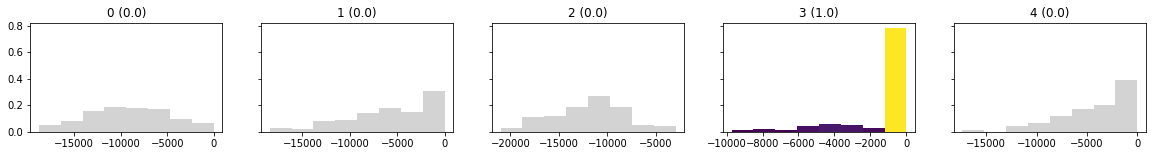

124
Incorrect :()
Real:  3
0.0
0.0
0.0
1.0
0.0


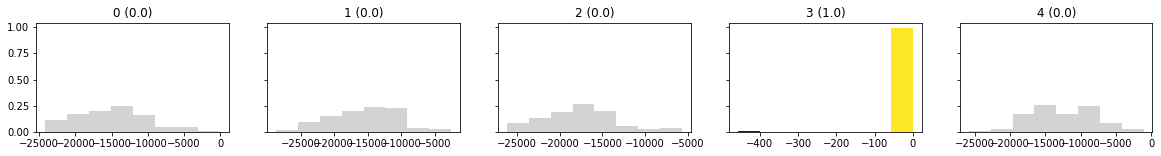

125
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


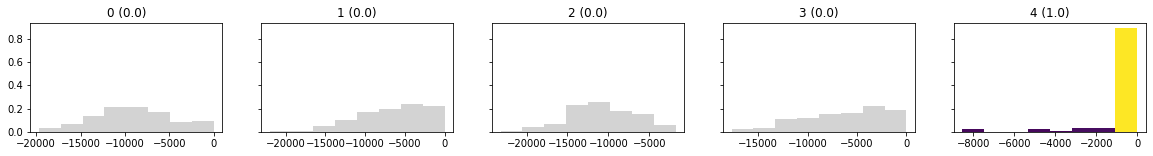

126
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


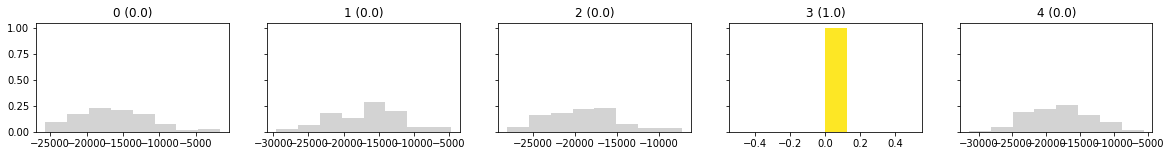

127
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


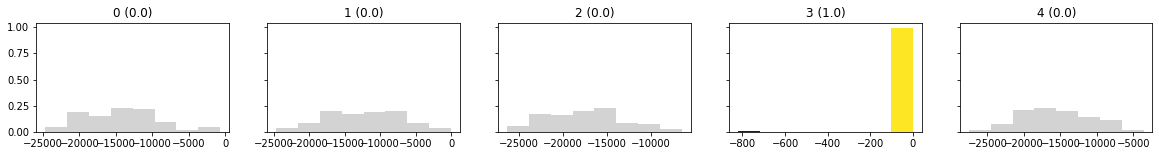

128
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


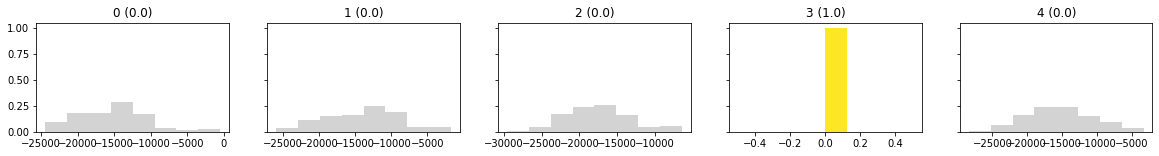

129
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


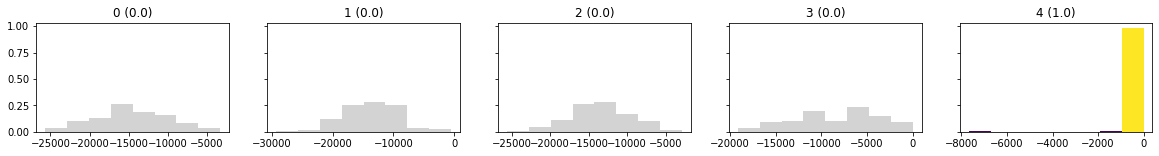

130
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


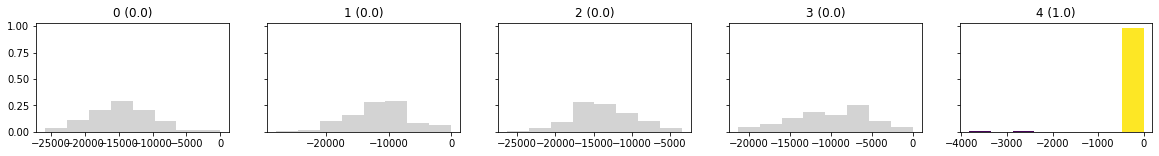

131
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


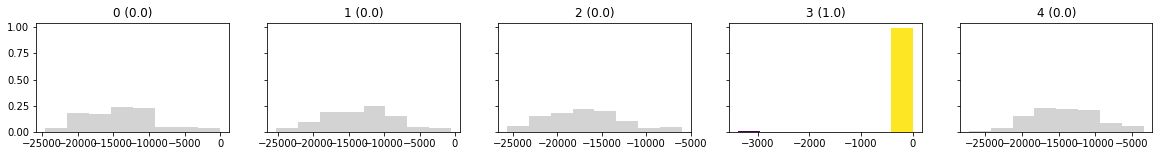

132
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


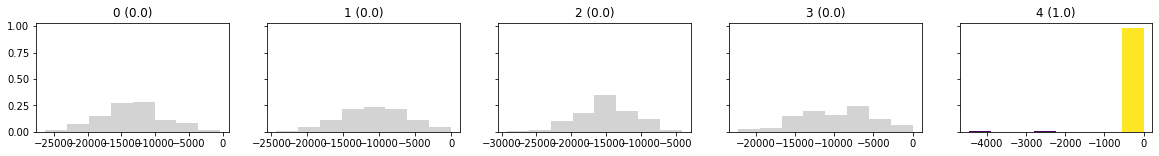

133
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


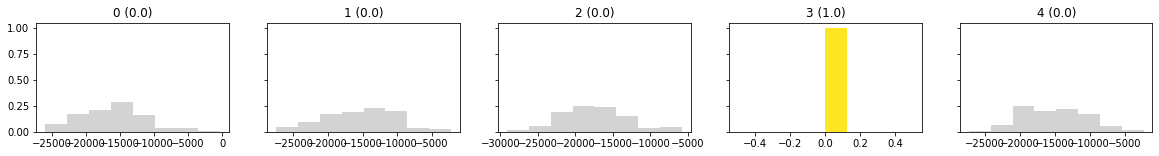

134
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


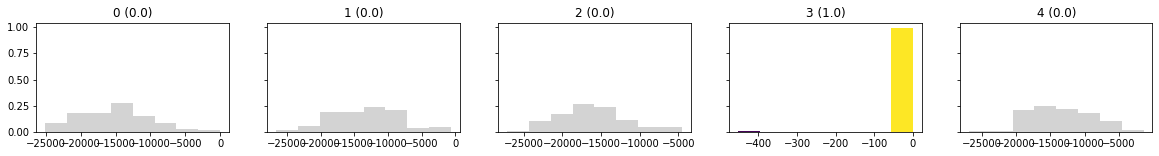

135
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


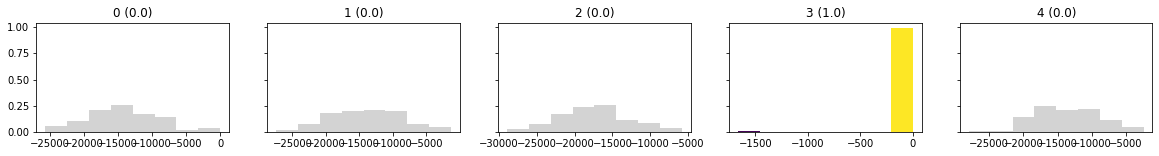

136
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


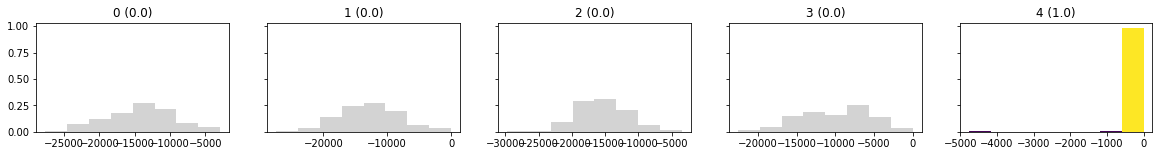

137
Correct
Real:  2
0.0
0.0
1.0
0.0
0.0


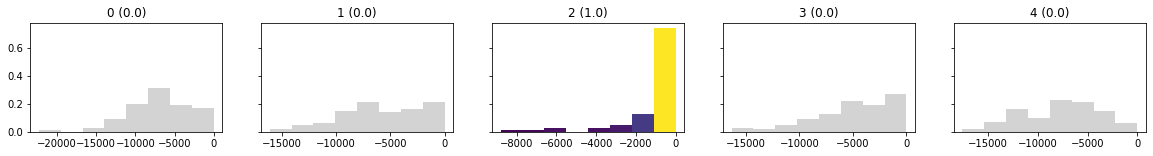

138
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


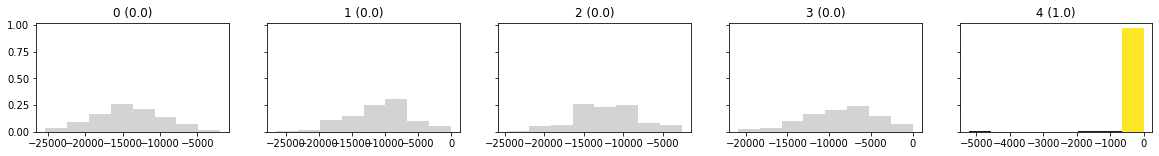

139
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


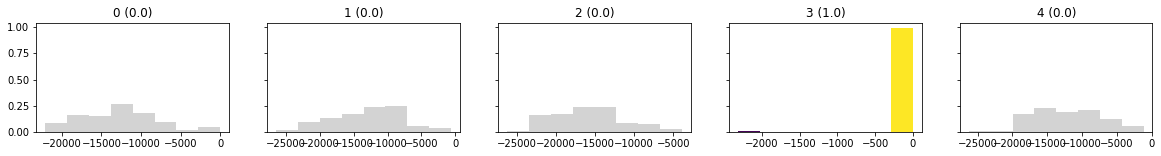

140
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


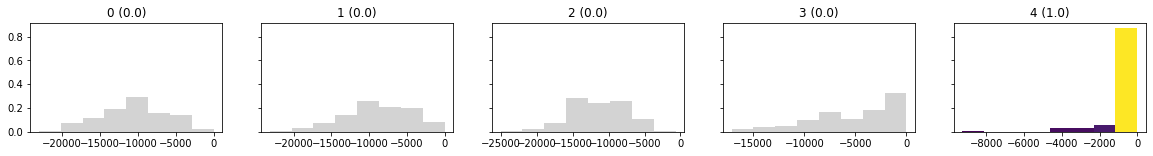

141
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


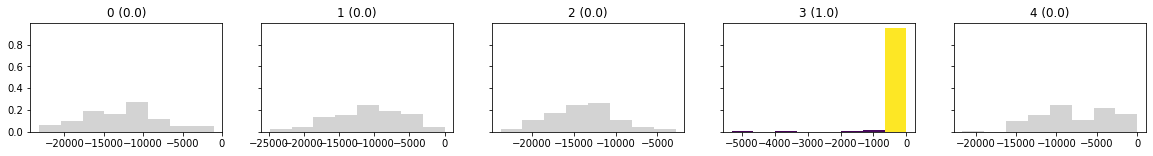

142
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


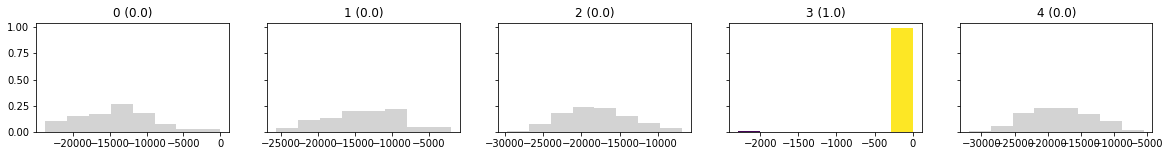

143
Correct
Real:  0
0.0
1.0
0.0
0.0
0.0


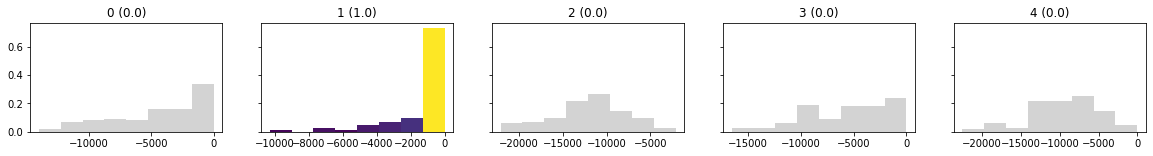

144
Incorrect :()
Real:  3
0.0
0.0
0.0
1.0
0.0


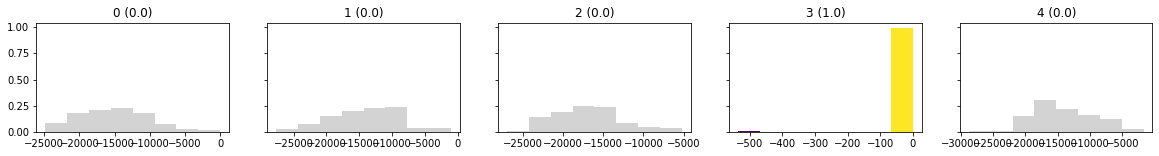

145
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


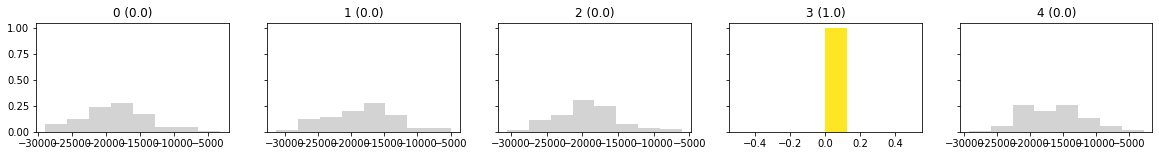

146
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


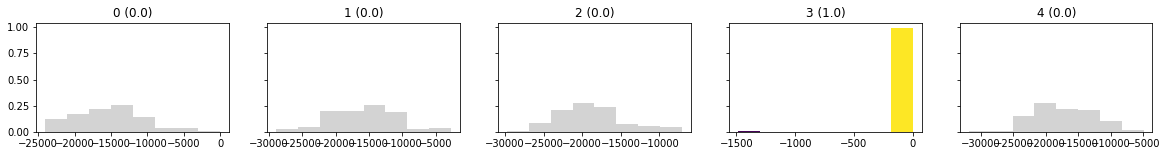

147
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


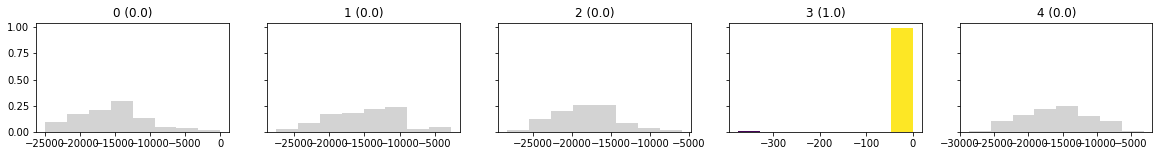

148
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


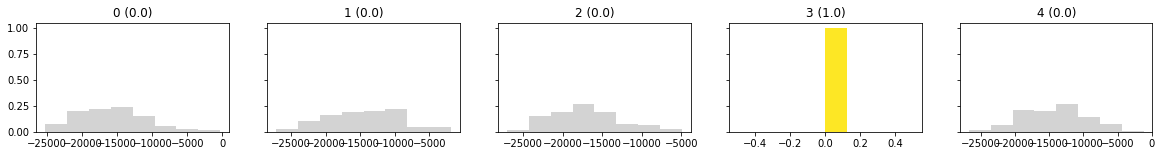

149
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


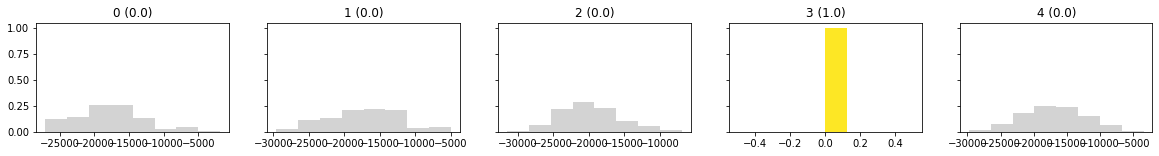

150
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


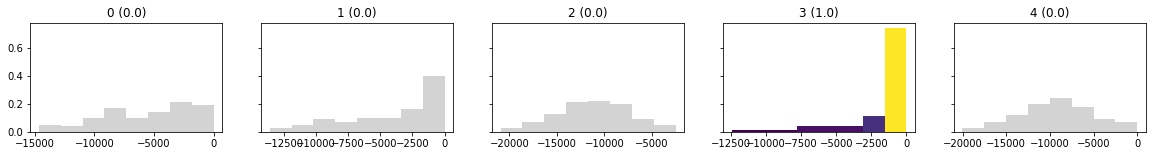

151
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


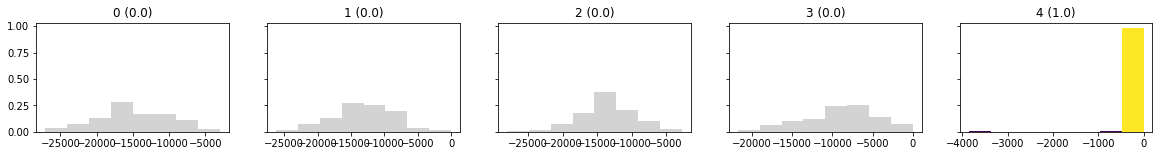

152
Correct
Real:  2
0.0
0.0
1.0
0.0
0.0


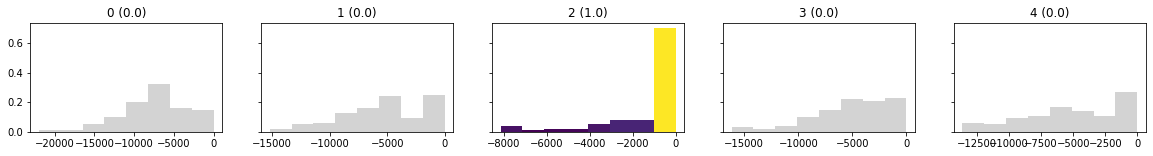

153
Correct
Real:  4
0.0
0.0
0.0
0.0
3.1226011998342074e-08


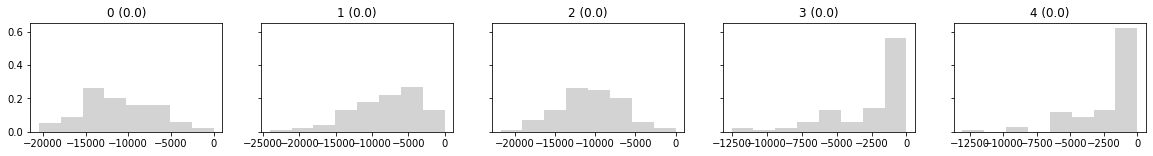

154
Undecided.
Real:  3
0.0
0.0
0.0
1.0
0.0


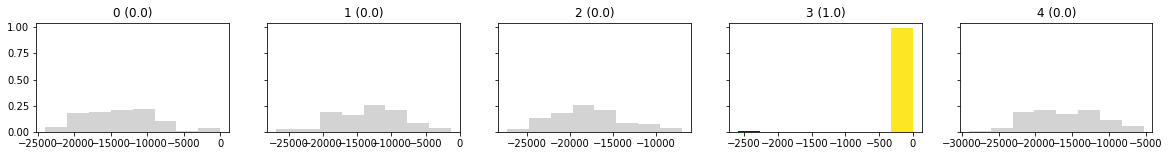

155
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


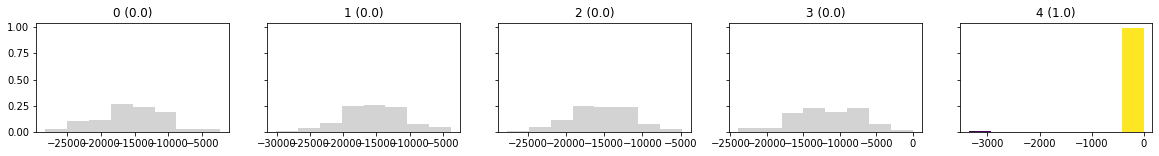

156
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


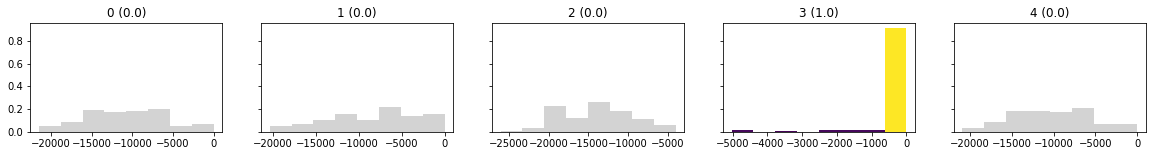

157
Correct
Real:  1
0.0
1.0
0.0
0.0
0.0


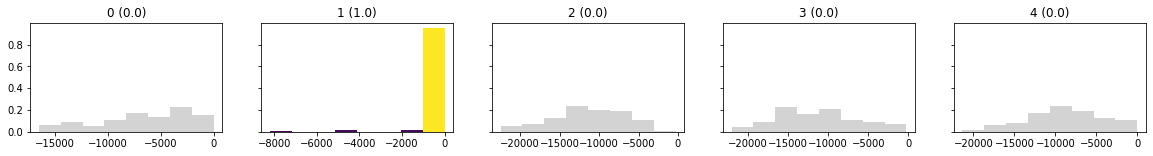

158
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


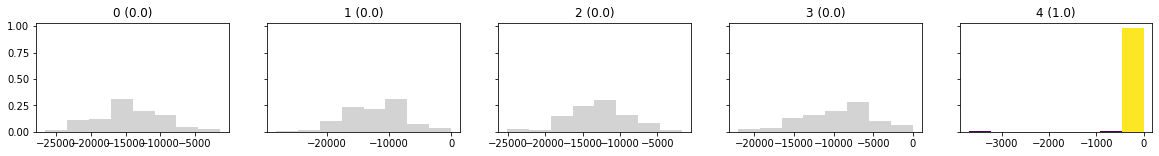

159
Correct
Real:  2
0.0
0.0
1.0
0.0
0.0


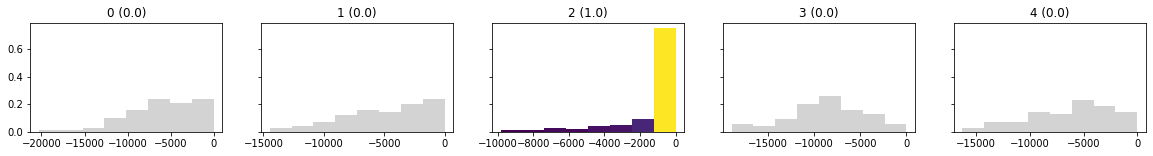

160
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


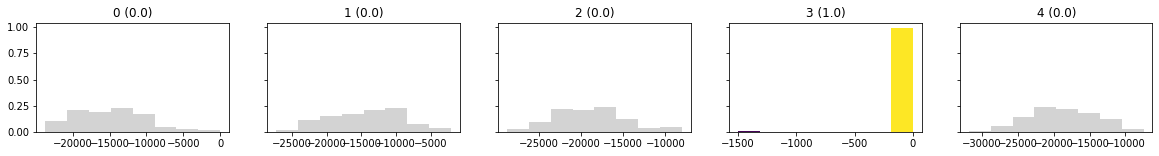

161
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


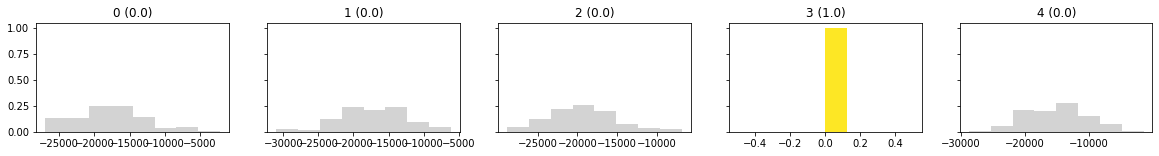

162
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


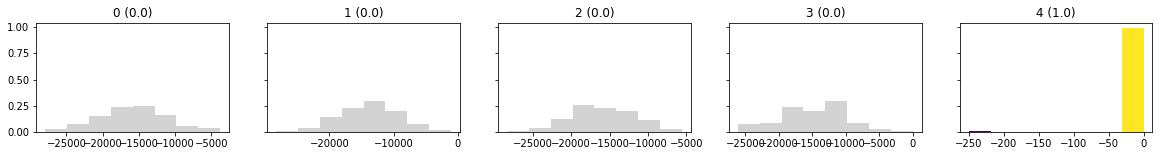

163
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


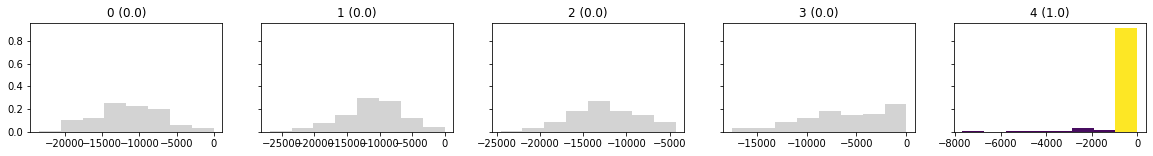

164
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


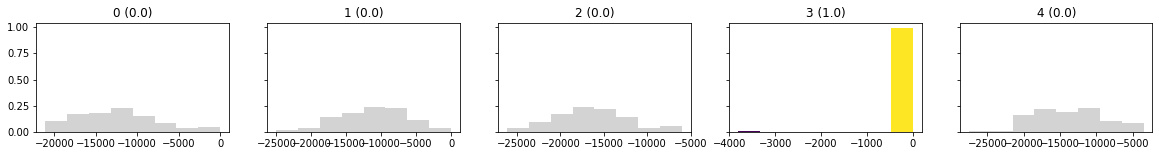

165
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


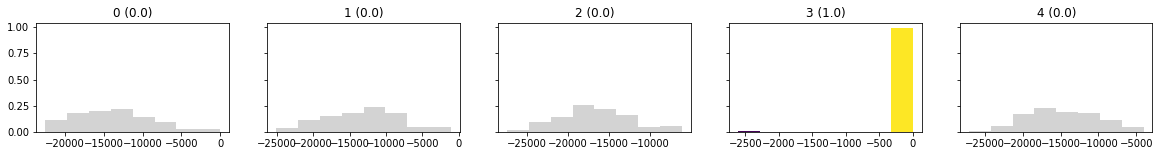

166
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


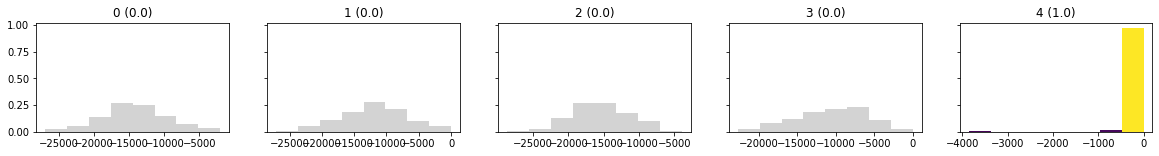

167
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


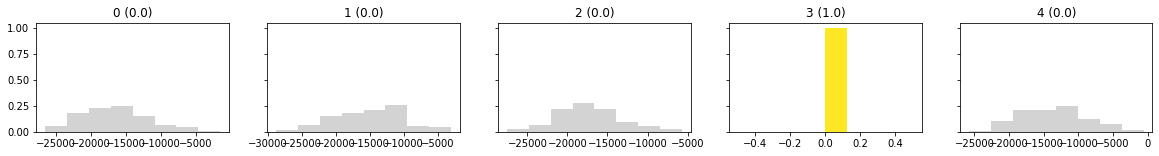

168
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


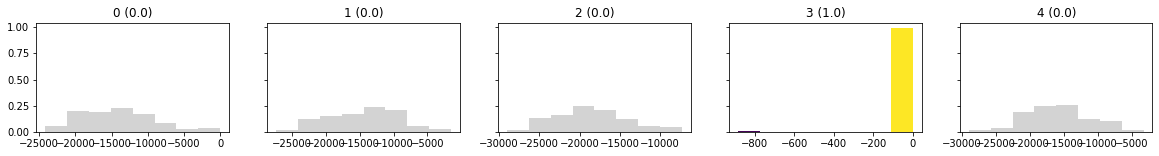

169
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


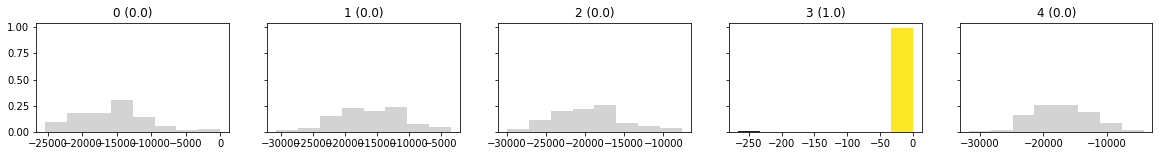

170
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


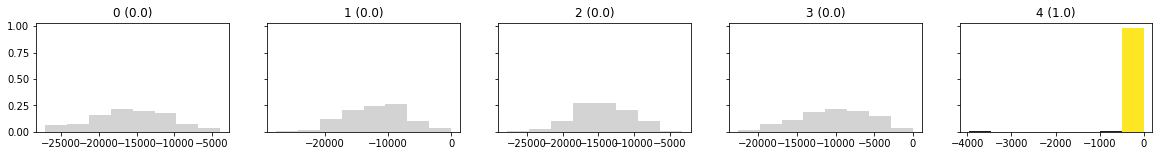

171
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


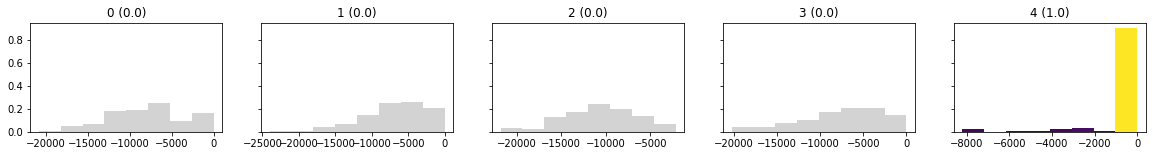

172
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


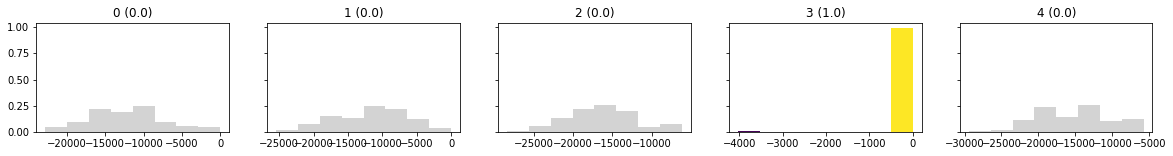

173
Correct
Real:  2
0.0
0.0
1.0
0.0
0.0


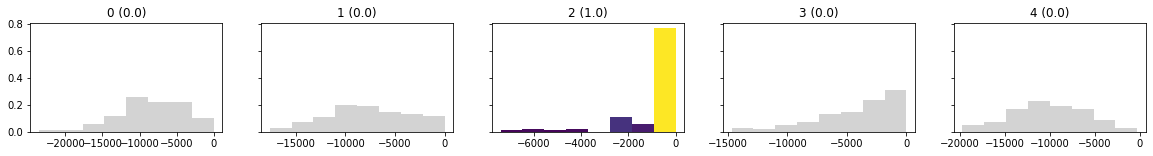

174
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


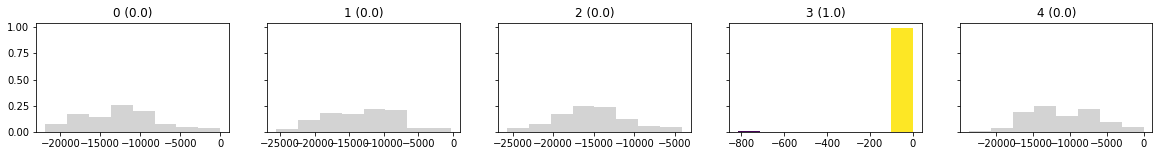

175
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


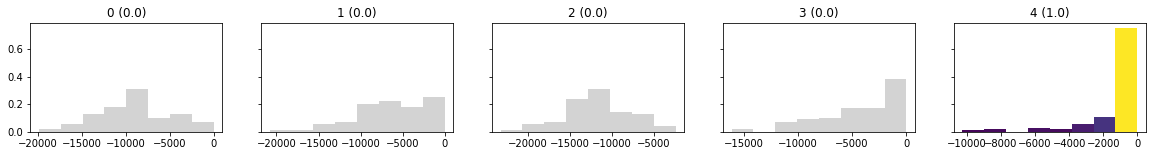

176
Correct
Real:  3
0.0
0.0
1.0
0.0
0.0


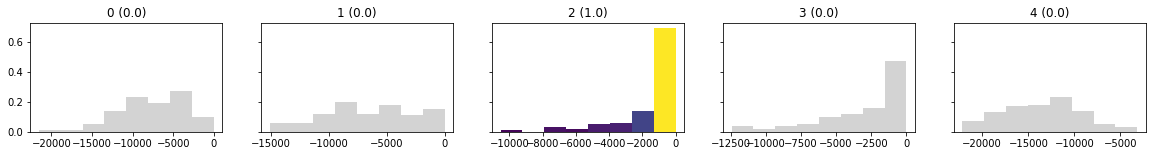

177
Incorrect :()
Real:  3
0.0
0.0
0.0
1.0
0.0


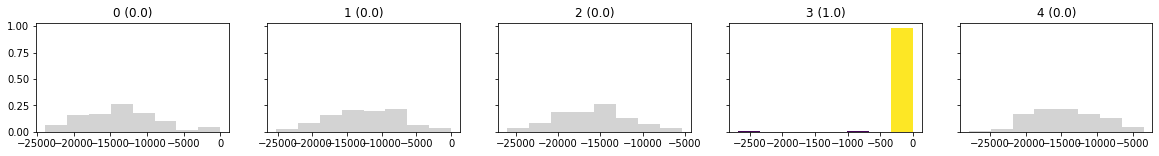

178
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


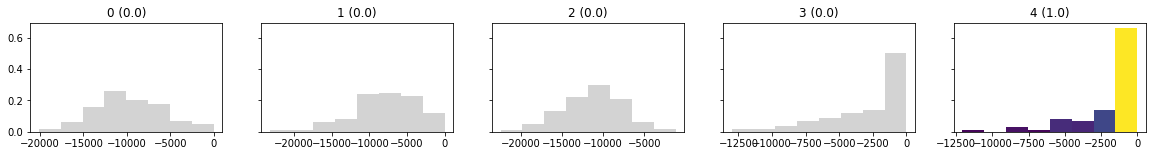

179
Correct
Real:  4
0.0
0.0
0.0
0.0
0.0


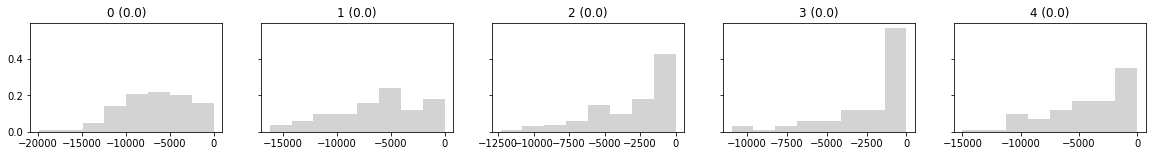

180
Undecided.
Real:  4
0.0
0.0
0.0
0.0
1.0


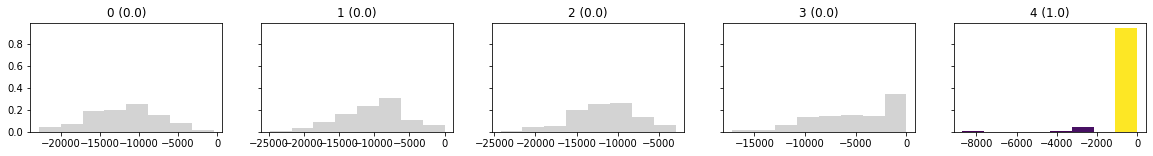

181
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


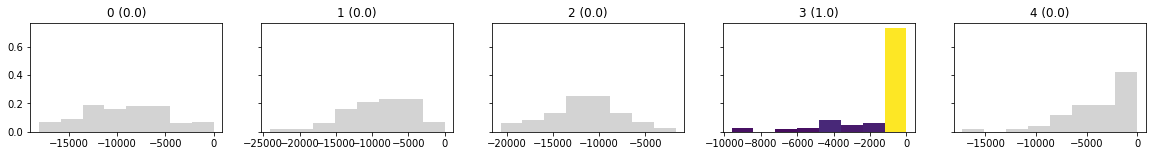

182
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


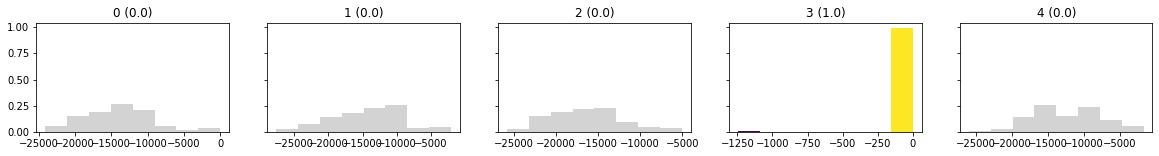

183
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


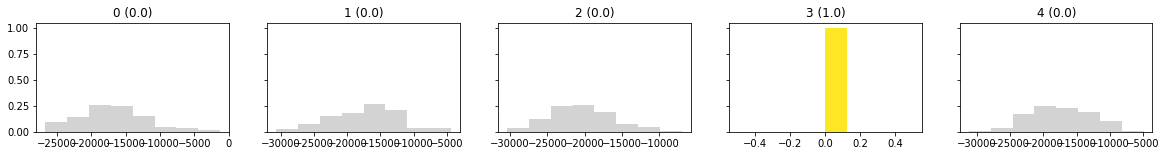

184
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


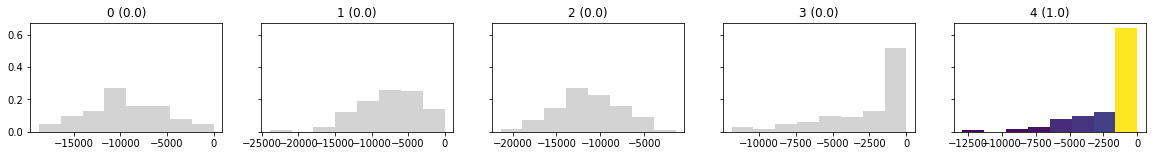

185
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


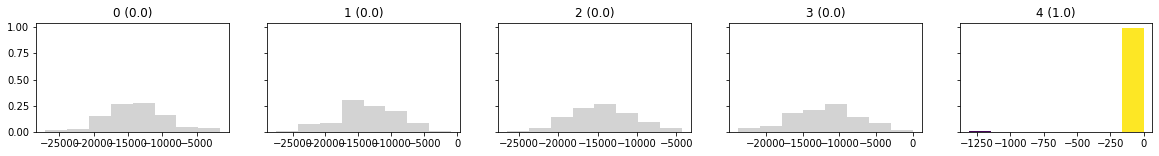

186
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


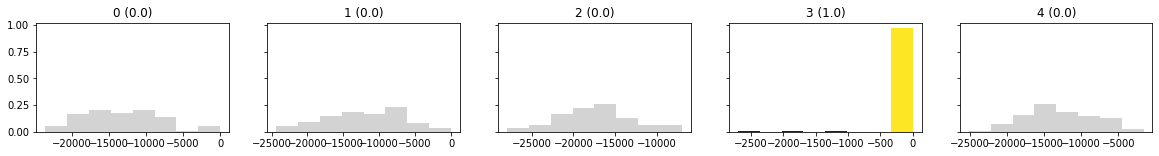

187
Correct
Real:  2
0.0
0.0
1.0
0.0
0.0


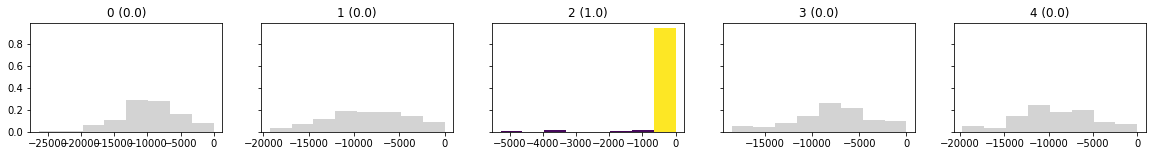

188
Correct
Real:  2
0.0
0.0
1.0
0.0
0.0


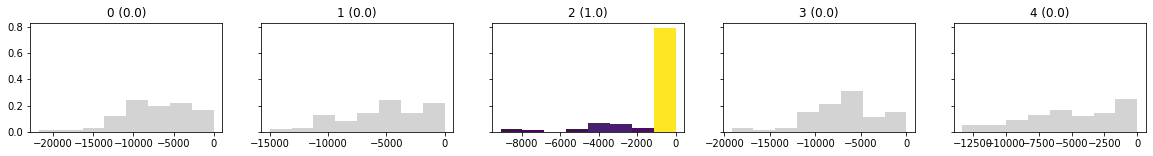

189
Correct
Real:  2
0.0
0.0
1.0
0.0
0.0


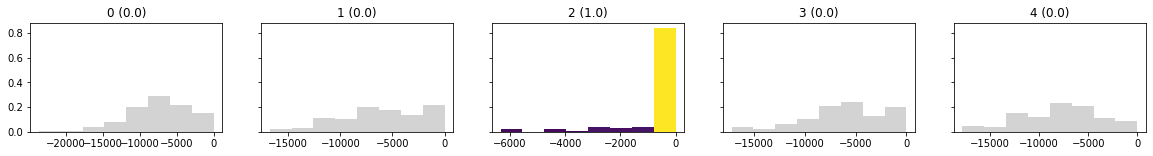

190
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


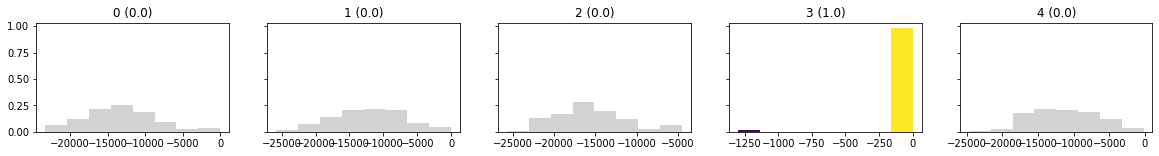

191
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


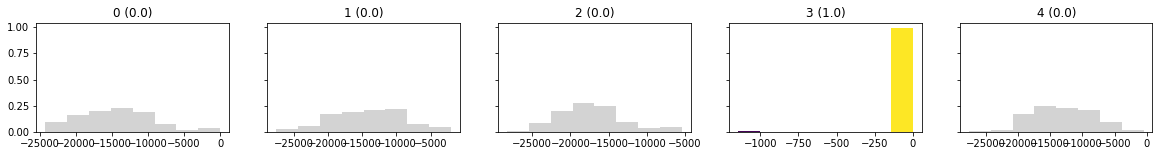

192
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


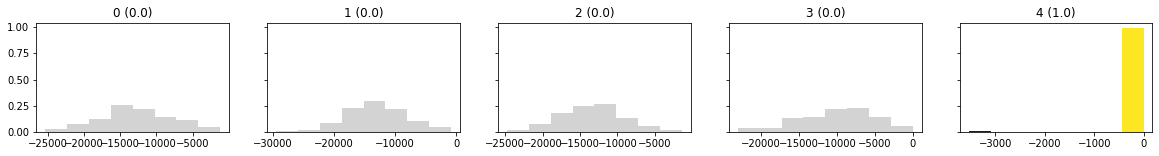

193
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


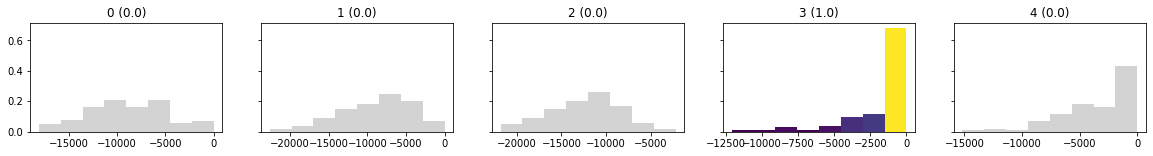

194
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


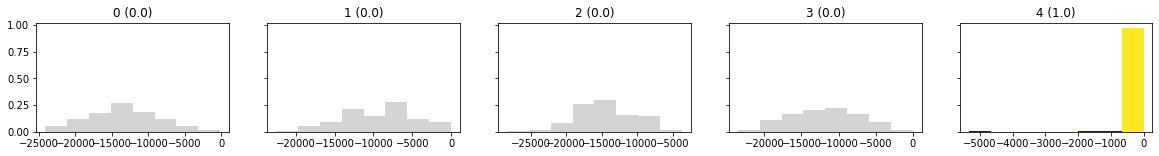

195
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


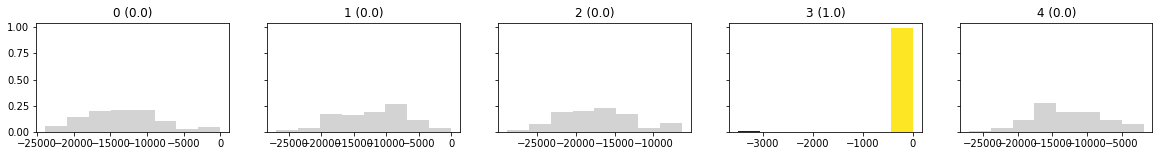

196
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


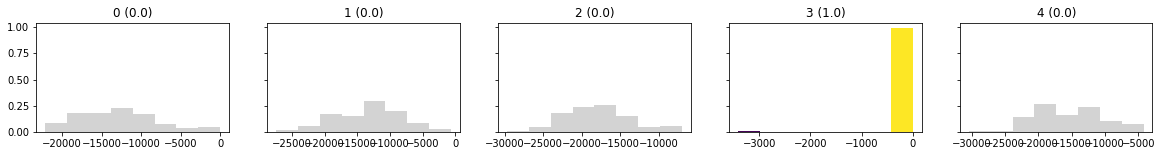

197
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


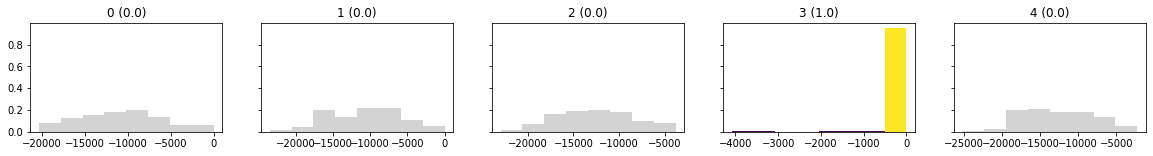

198
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


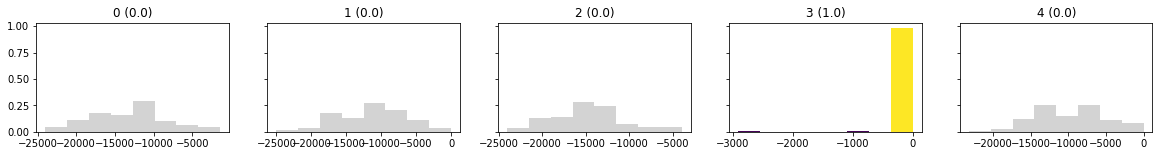

199
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


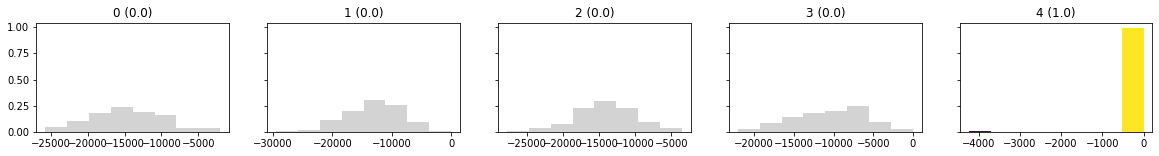

200
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


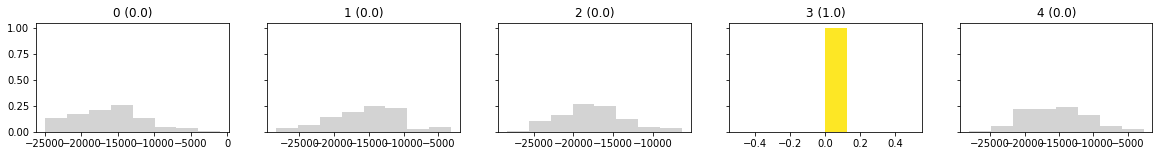

201
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


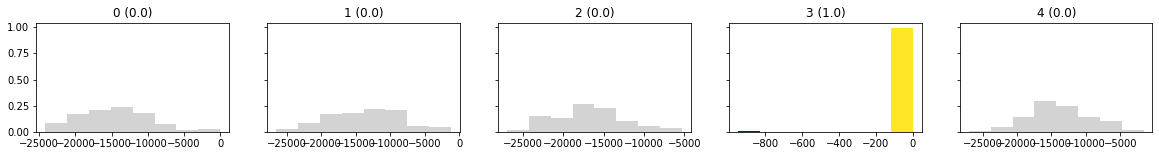

202
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


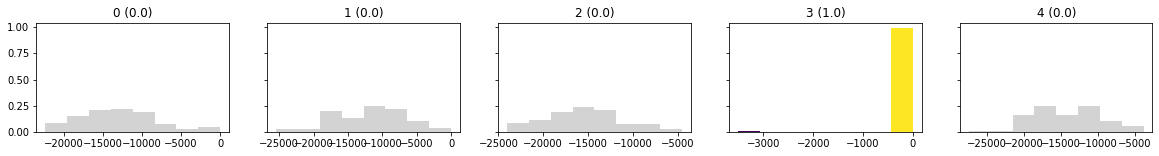

203
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


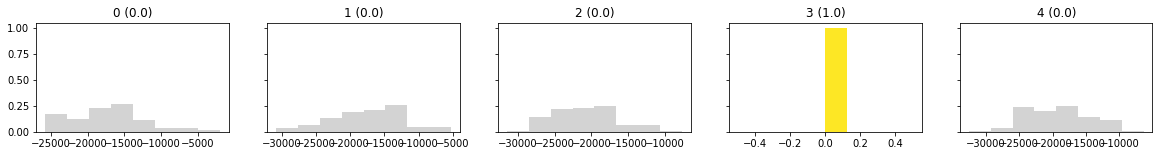

204
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


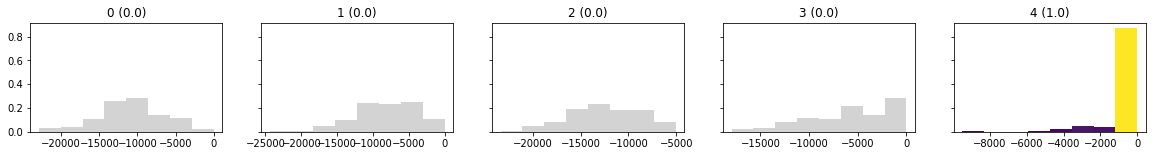

205
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


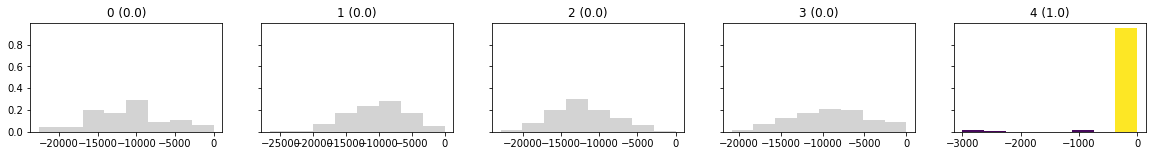

206
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


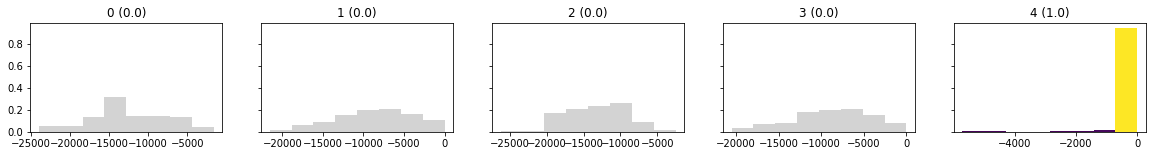

207
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


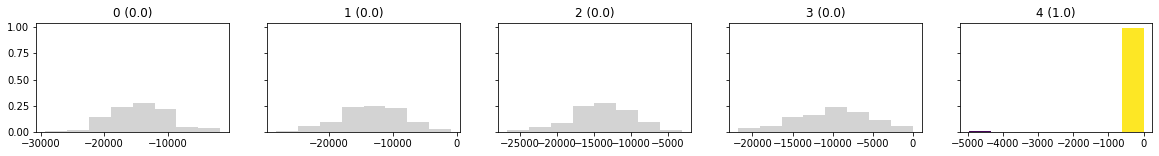

208
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


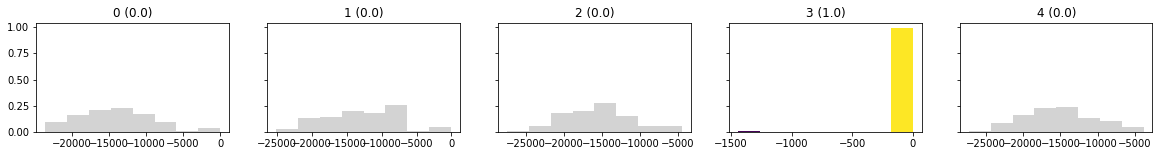

209
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


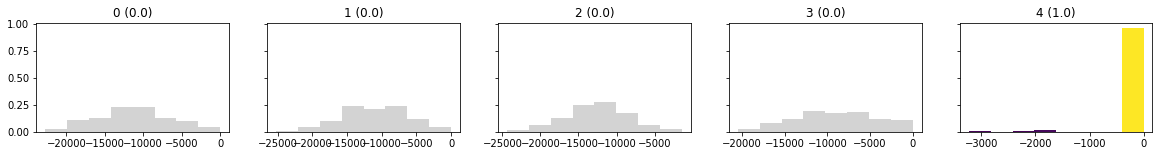

210
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


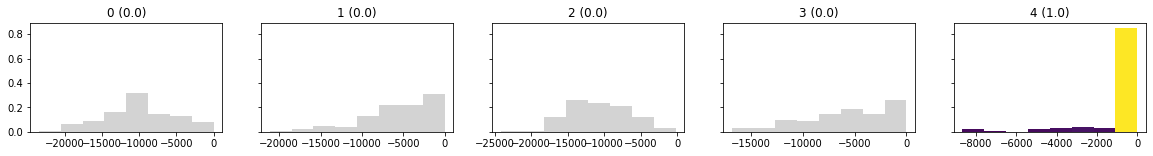

211
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


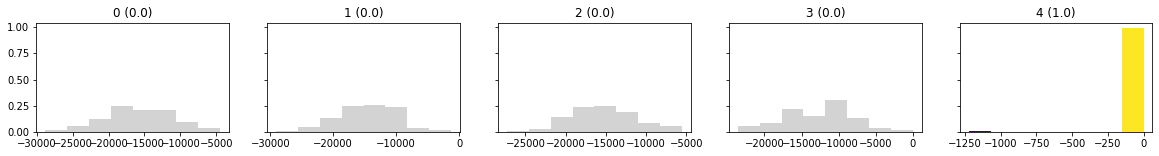

212
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


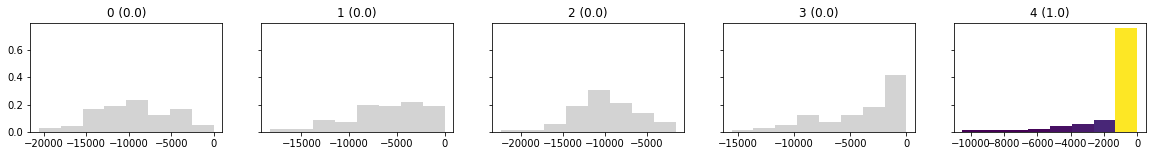

213
Correct
Real:  1
0.0
1.0
0.0
0.0
0.0


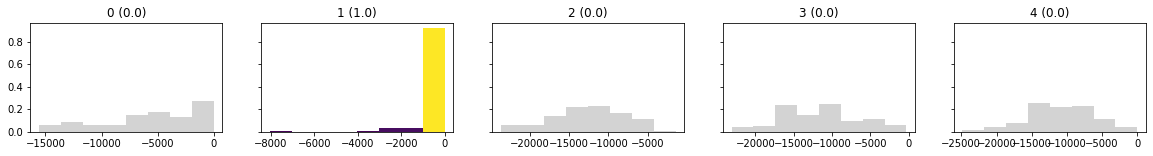

214
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


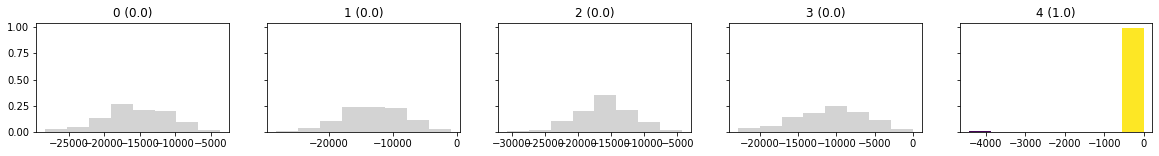

215
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


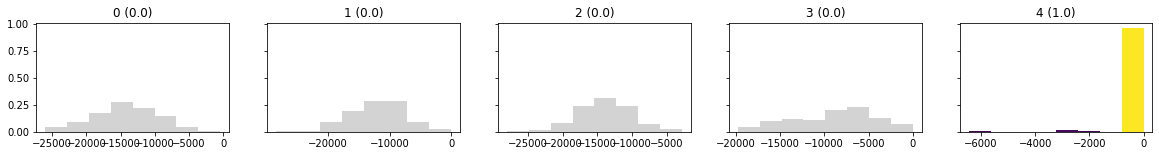

216
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


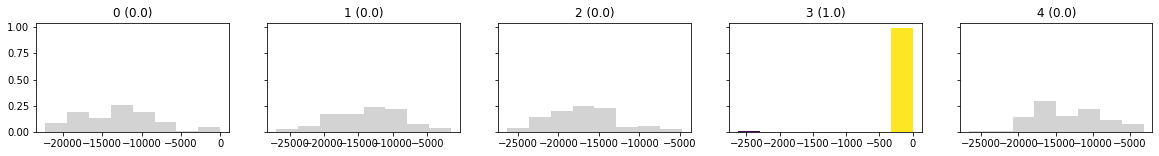

217
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


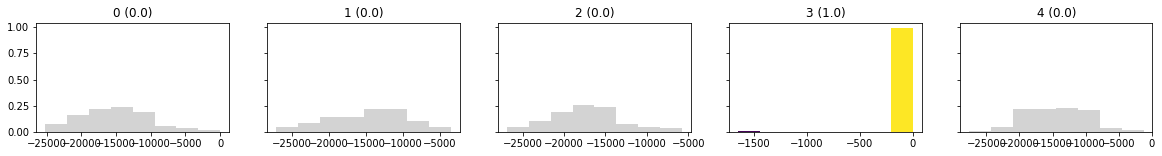

218
Correct
Real:  3
0.0
0.0
0.0
1.0
0.0


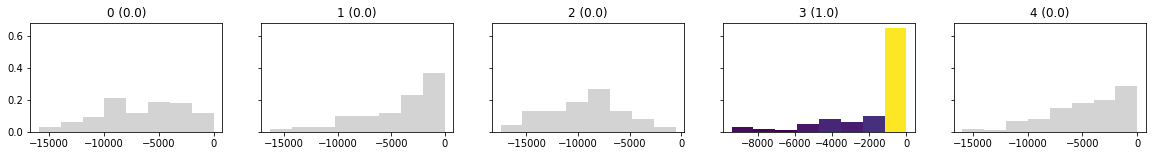

219
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


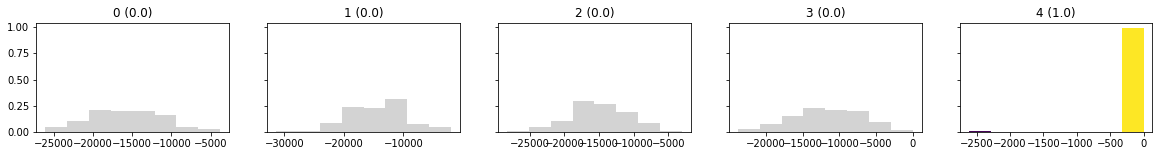

220
Correct
Real:  0
1.0
0.0
0.0
0.0
0.0


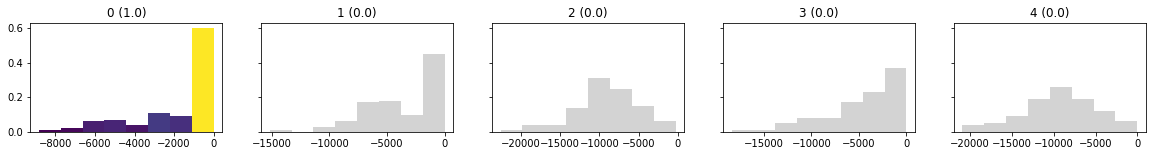

221
Correct
Real:  4
0.0
0.0
0.0
0.0
0.0


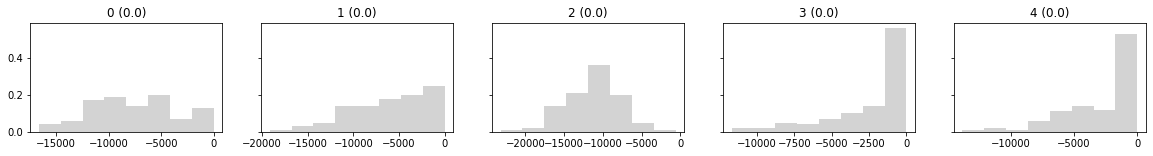

222
Undecided.
Real:  4
0.0
0.0
0.0
0.0
1.0


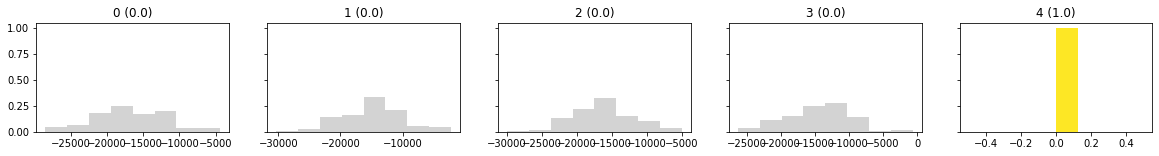

223
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


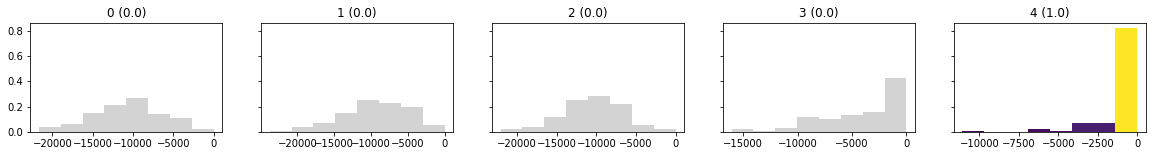

224
Correct
Real:  4
0.0
0.0
0.0
0.0
1.0


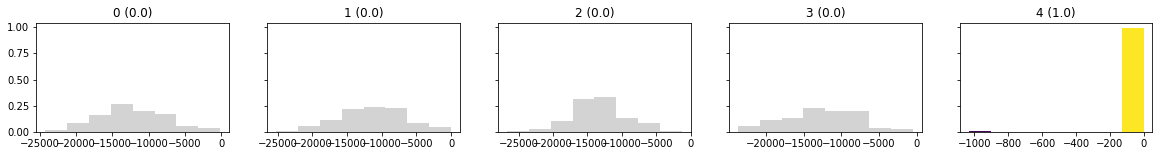

225
Correct
Real:  2
0.0
0.0
0.0
0.0
0.0


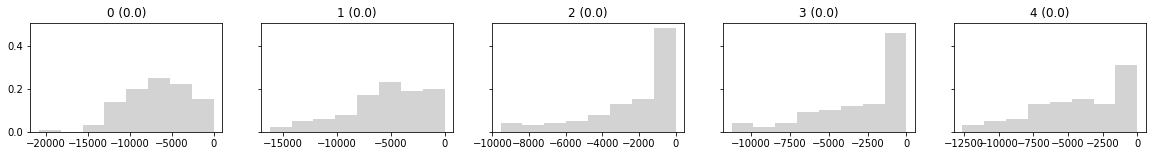

226
Undecided.
Real:  4
0.0
0.0
0.0
0.0
1.0


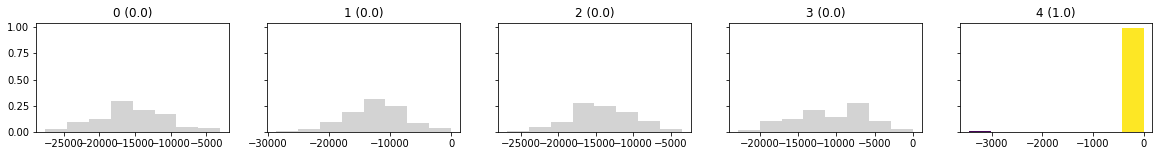

227
Correct
Summary
Total images:  228
Predicted for:  218
Accuracy when predicted:  0.9770642201834863


(228, 213.0, 218)

In [65]:
import matplotlib.pyplot as plt
test_batch(torch.from_numpy(X_test.to_numpy()).float(),y_test.to_numpy())

In [ ]:
annotation_path = "../Data/data/sarc-preprocessed_annotation_global.csv"
y = pd.read_csv(annotation_path)["label"]

y = y.astype('category').cat.codes
X = pd.read_csv("../Data/data/sarc-preprocessed_Matrix_miRNA_deseq_correct.csv").drop(columns=["Composite Element REF", "Unnamed: 0"])

Real:  0
0.0
1.0
0.0
0.0
0.0


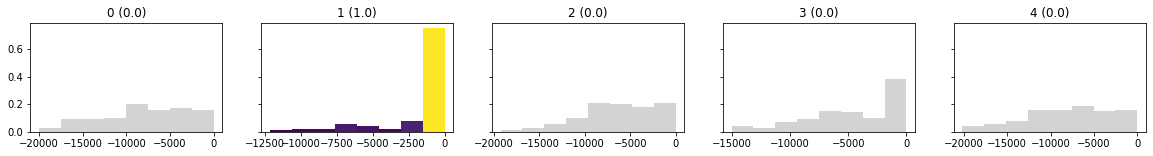

0
Incorrect :()
Real:  0
0.0
0.0
0.0
0.0
0.0


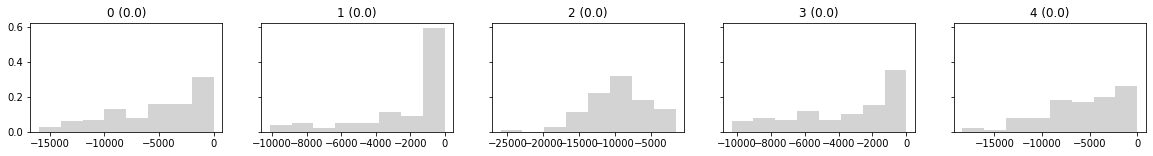

1
Undecided.
Summary
Total images:  2
Predicted for:  1
Accuracy when predicted:  0.0


(2, 0, 1)

In [66]:
test_batch(torch.from_numpy(X.to_numpy()).float(),y.to_numpy())

In [67]:
annotation_path = "../Data/data/preprocessed_annotation_global.csv"
y = pd.read_csv(annotation_path)["label"]

y = y.astype('category').cat.categories
y

Index(['sane-TCGA-KIRC', 'sane-TCGA-KIRP', 'tumor-TCGA-KICH',
       'tumor-TCGA-KIRC', 'tumor-TCGA-KIRP'],
      dtype='object')